In [1]:
# This part includes model training and may be time-consuming.
# To run this file, it will cost about 4000 CPU seconds, about 10-25 minutes depends on CPU performance.

import pandas as pd 
import os
import numpy as np
import missingno as msno
from sklearn.cluster import KMeans
import colorsys
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import hsv_to_rgb
import pickle 
import re
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold,GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from scipy.stats import randint, uniform
import seaborn as sns


label_fontsize, title_fontsize = 14, 16
def sns_box_plot(model_results, title='Distribution of R2 Scores for Linear Regression', ylabel='R2 Score', xlabel='Models',
                 ylim = (0,0.7) ,figsize=(6, 4.5),rotation=0, label_fontsize=label_fontsize, title_fontsize=title_fontsize):
    
    df = pd.DataFrame.from_dict(model_results, orient='index').transpose()
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, width=0.5, palette='Set2')  #, orient='h'
    plt.ylim(ylim) 
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(rotation=rotation, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.grid(True)
    plt.show()


def quick_view_df(df,num=3):
    return pd.concat([df[:num],df[-num:]])


# load variables
PKL_FILENAME4 = r'data/variables4.pkl'
PKL_RES = r'data/res.pkl'

with open(PKL_FILENAME4, 'rb') as file:
    loaded_data = pickle.load(file)
(dataset_price,features) = loaded_data
del loaded_data

dataset_price['Price_1'].drop(columns = ['year'],inplace = True)
dataset_price['Price_2'].drop(columns = ['year'],inplace = True)
dataset_price['Price_1'].rename(columns = {'set_number':'set_num'}, inplace = True)
dataset_price['Price_2'].rename(columns = {'set_number':'set_num'}, inplace = True)
dataset_price['Price_3'].rename(columns = {'set_number':'set_num'}, inplace = True)
msrp = dataset_price['Price_msrp'][['Set_ID','USD_MSRP']]
msrp.columns = ['set_num','msrp']

import datetime
datetime.datetime.now()


datetime.datetime(2024, 2, 15, 22, 5, 45, 923397)

In [2]:
display(
    dataset_price.keys()
    #,features.head(2)
    ,quick_view_df(dataset_price['Price_1'],1)
    ,quick_view_df(dataset_price['Price_2'],1)
    ,quick_view_df(dataset_price['Price_3'],1)
)

dict_keys(['Price_1', 'Price_2', 'Price_3', 'Price_msrp', 'small_sample'])

set_num                theme           name  pieces  minifigs  price
0        659-1             LEGOLAND  Police Patrol    49.0       2.0  55.00
5441  682303-1  Marvel Super Heroes  Miles Morales     8.0       1.0   6.95

set_num            theme                                    name  \
0     10196-1  Advanced models                          Grand Carousel   
2321  10205-1           Trains  “Large Train Engine with Tender,Black”   

      pieces  minifigs        price  price_2018  
0       3263       9.0  3192.543536  1293.05125  
2321     232       0.0   200.297625    81.12500

price  set_num                                                url
0     19.49  10904-1  https://www.brickeconomy.com/set/10904-1/lego-...
6328  14.10  40484-1  https://www.brickeconomy.com/set/40484-1/lego-...

<Axes: >

<Axes: >

<Axes: >

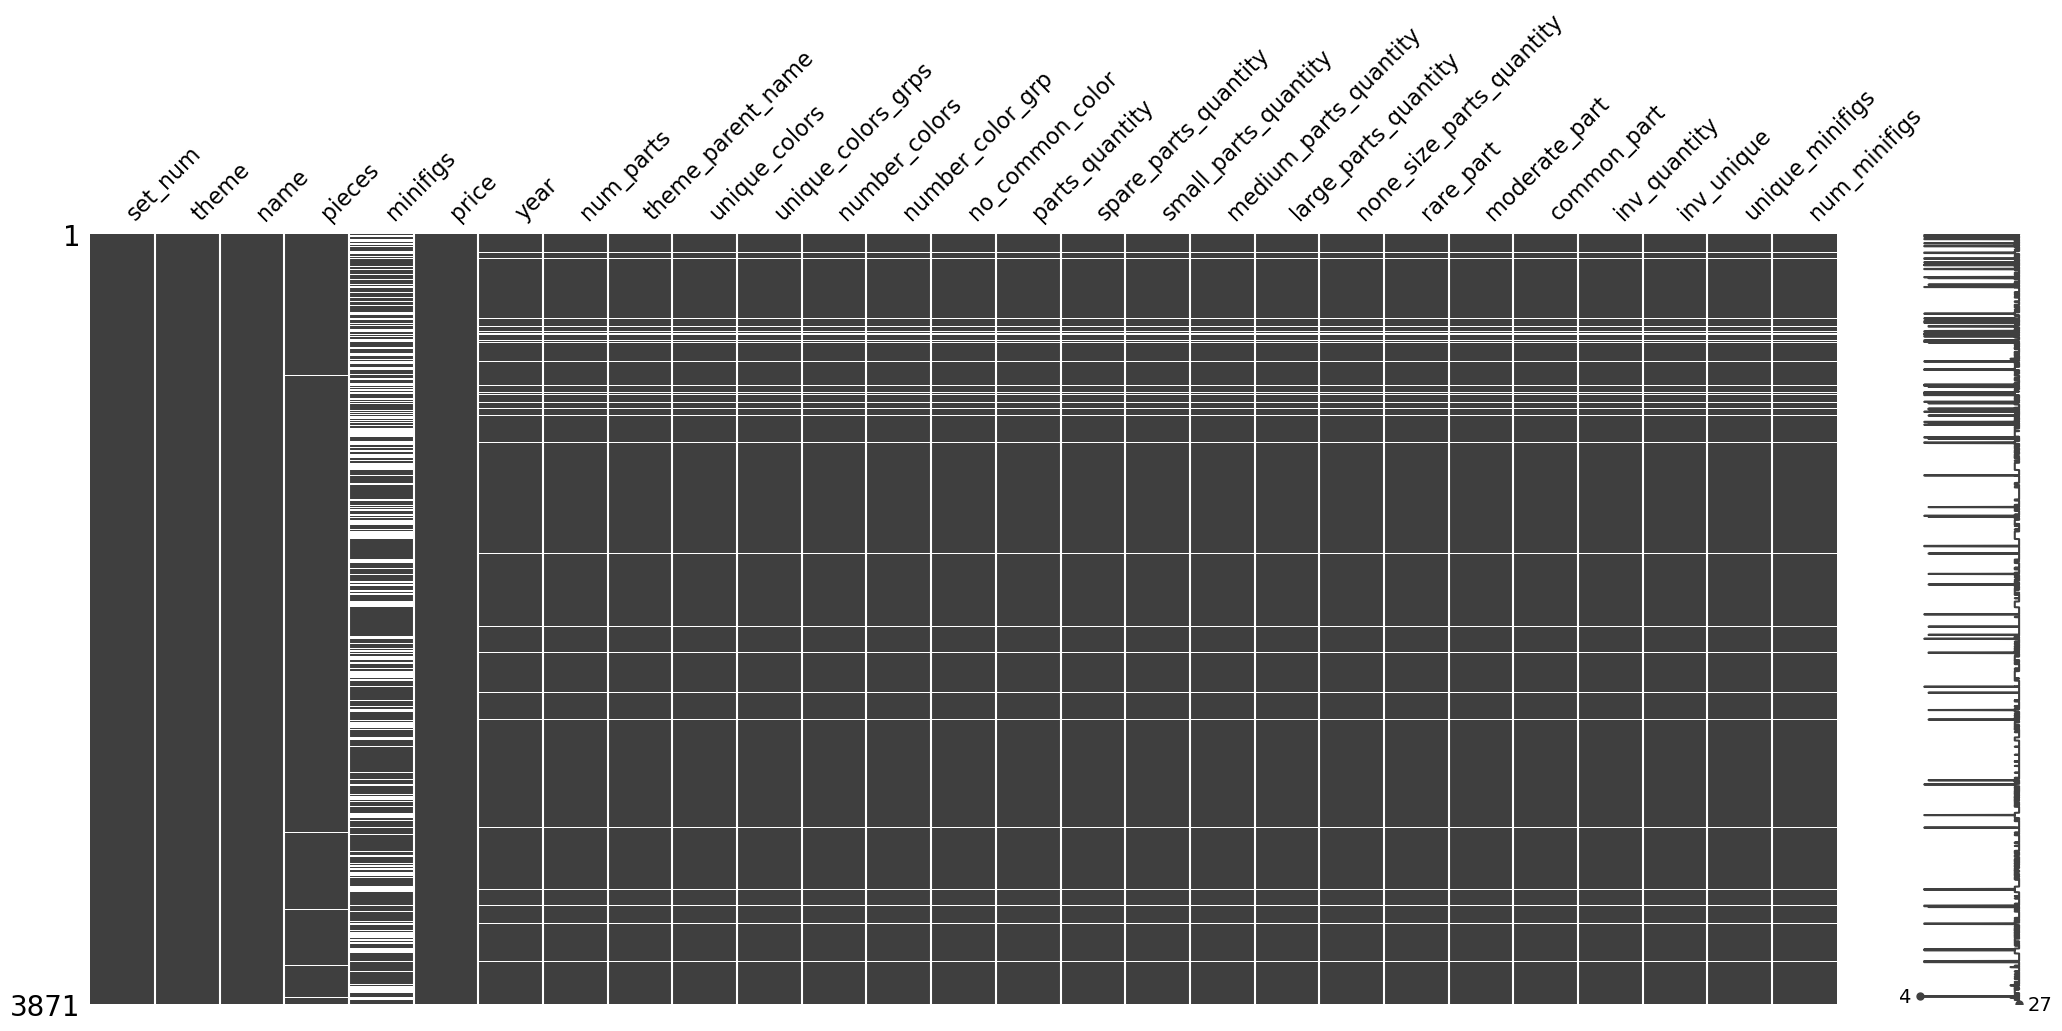

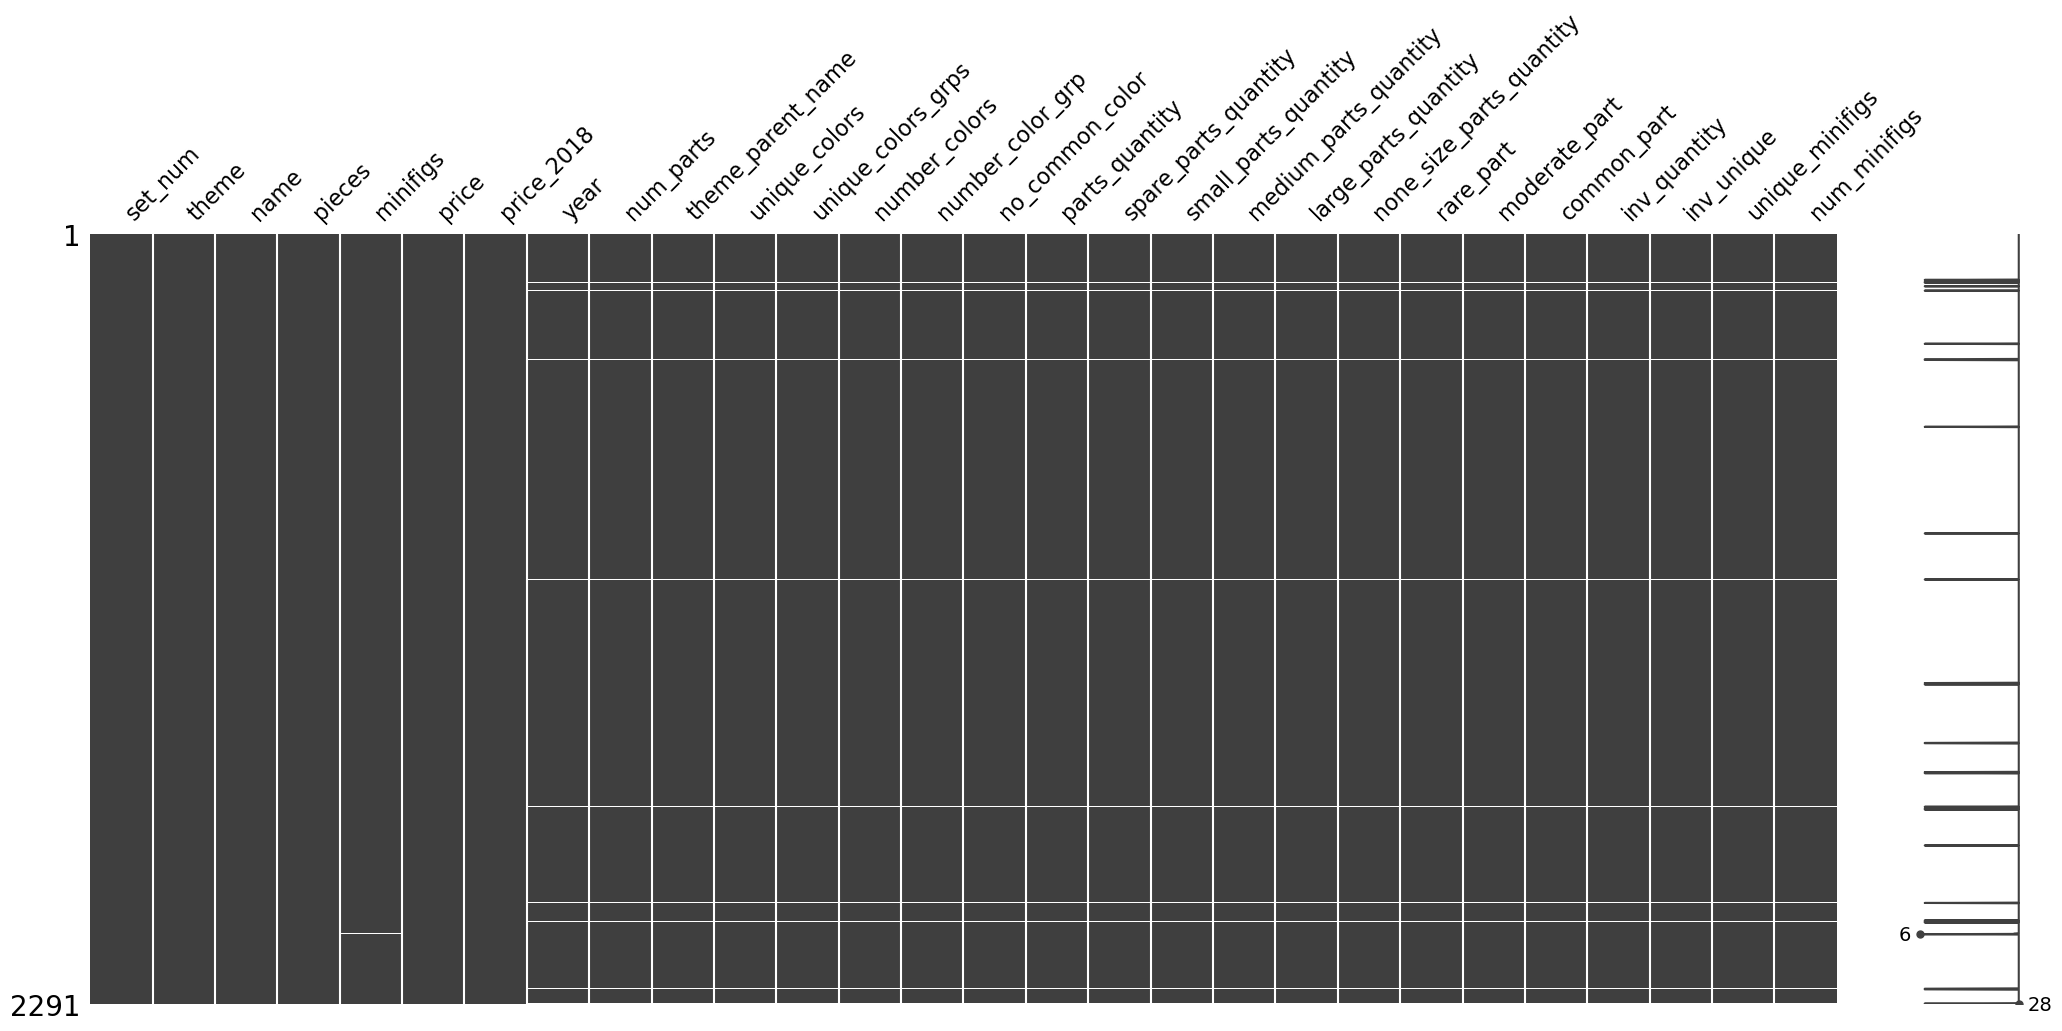

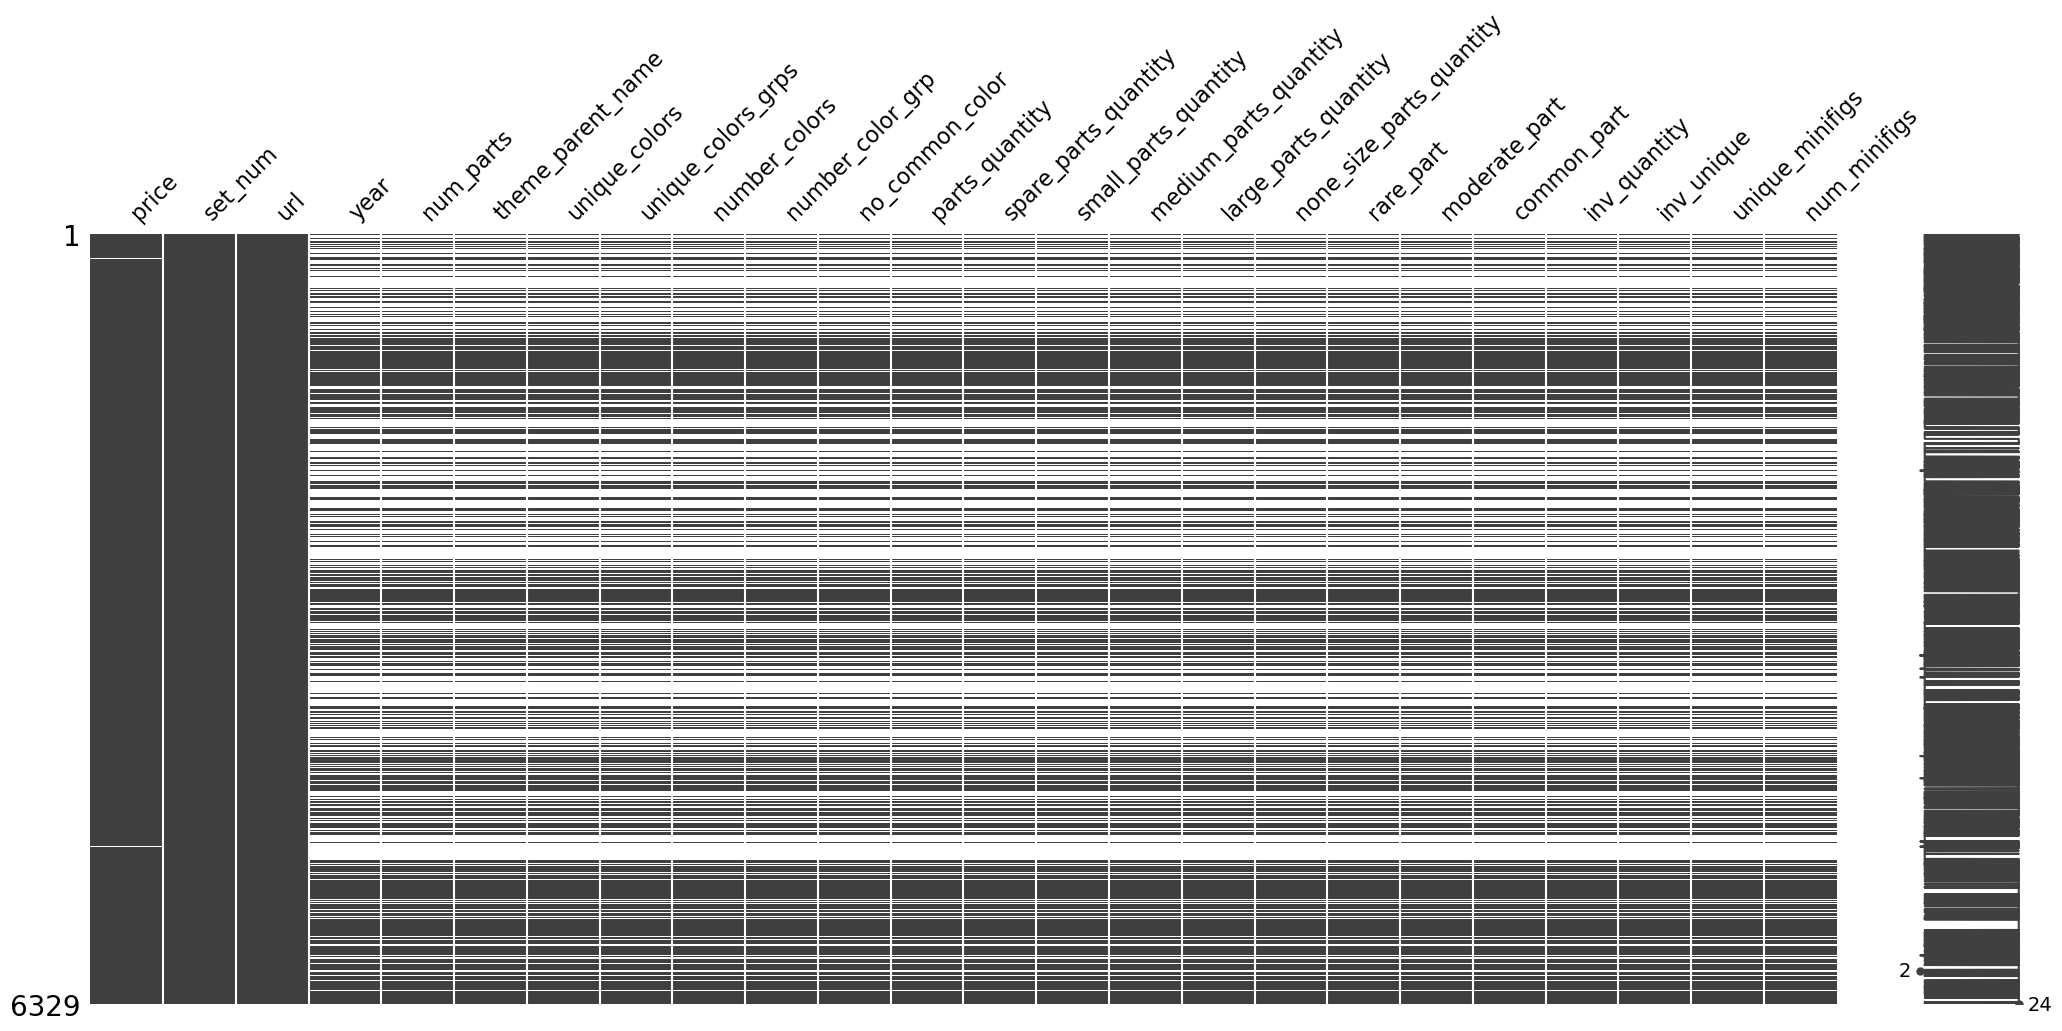

In [3]:
df1 = dataset_price['Price_1'].merge(features,how = 'left',on = 'set_num')
df2 = dataset_price['Price_2'].merge(features,how = 'left',on = 'set_num')
df3 = dataset_price['Price_3'].merge(features,how = 'left',on = 'set_num')
display(
    msno.matrix(df1),msno.matrix(df2),msno.matrix(df3)
)

In [4]:
df1 = dataset_price['Price_1'].merge(features,how = 'inner',on = 'set_num')
df2 = dataset_price['Price_2'].merge(features,how = 'inner',on = 'set_num')
df3 = dataset_price['Price_3'].merge(features,how = 'inner',on = 'set_num').dropna()


temp = pd.concat([df1,df2,df3]).reset_index()
temp['theme_PPP'] = temp['price']/(temp['pieces']+1)
feature_theme = temp.groupby('theme_parent_name')['theme_PPP'].mean().fillna(0).sort_values().reset_index()
#del temp

df1 = df1.merge(feature_theme,how = 'left', on = 'theme_parent_name')
df2 = df2.merge(feature_theme,how = 'left', on = 'theme_parent_name')
df3 = df3.merge(feature_theme,how = 'left', on = 'theme_parent_name')
df3 = df3[~df3['set_num'].isin( list(pd.concat([df1['set_num'], df2['set_num']])) ) ] .reset_index(drop = True)
df3['price'] = pd.to_numeric(df3['price'])

feature_names = ['year', 'theme_PPP', 'num_parts', 'parts_quantity','small_parts_quantity', 'medium_parts_quantity',
                 'large_parts_quantity', 'none_size_parts_quantity', 'rare_part','moderate_part', 'spare_parts_quantity',
                 'common_part', 'inv_quantity', 'inv_unique','unique_minifigs', 'num_minifigs','number_colors', 'number_color_grp'
                ]
df_all = pd.concat([df1[['set_num','theme_parent_name']+feature_names + ['price']], 
                    df2[['set_num','theme_parent_name']+feature_names + ['price']], 
                    df3[['set_num','theme_parent_name']+feature_names + ['price']]])
#display(    quick_view_df(df1,2), quick_view_df(df2,2), quick_view_df(df3,2)  )

df_msrp = msrp.merge(df_all,how='inner',on='set_num')
df_msrp['price_increase'] = df_msrp['price']/df_msrp['msrp']-1
df_msrp['price_increase_per_year'] = df_msrp['price_increase']/(2024-df_msrp['year'])

feature_theme = feature_theme.merge(df_msrp.groupby('theme_parent_name')['price_increase'].mean().fillna(0).sort_values().reset_index(), how = 'outer',on = 'theme_parent_name')
feature_theme = feature_theme.merge(df_msrp.groupby('theme_parent_name')['price_increase_per_year'].mean().fillna(0).sort_values().reset_index(), how = 'outer',on = 'theme_parent_name')
feature_theme.columns = ['theme_parent_name', 'theme_PPP', 'theme_pi','theme_pipp']
df_msrp = df_msrp.merge(feature_theme[['theme_parent_name', 'theme_pi', 'theme_pipp']],how = 'left',on = 'theme_parent_name')
#sns.boxplot(x = df_msrp['price_increase']/(2024-df_msrp['year']) )

temp = df_msrp.groupby('theme_parent_name')['set_num'].count().sort_values(ascending = False).reset_index()[:20]['theme_parent_name']
temp = list(temp)
df_msrp['theme'] = df_msrp['theme_parent_name'].copy()
df_msrp.loc[~df_msrp['theme'].isin(temp), 'theme'] = 'others'

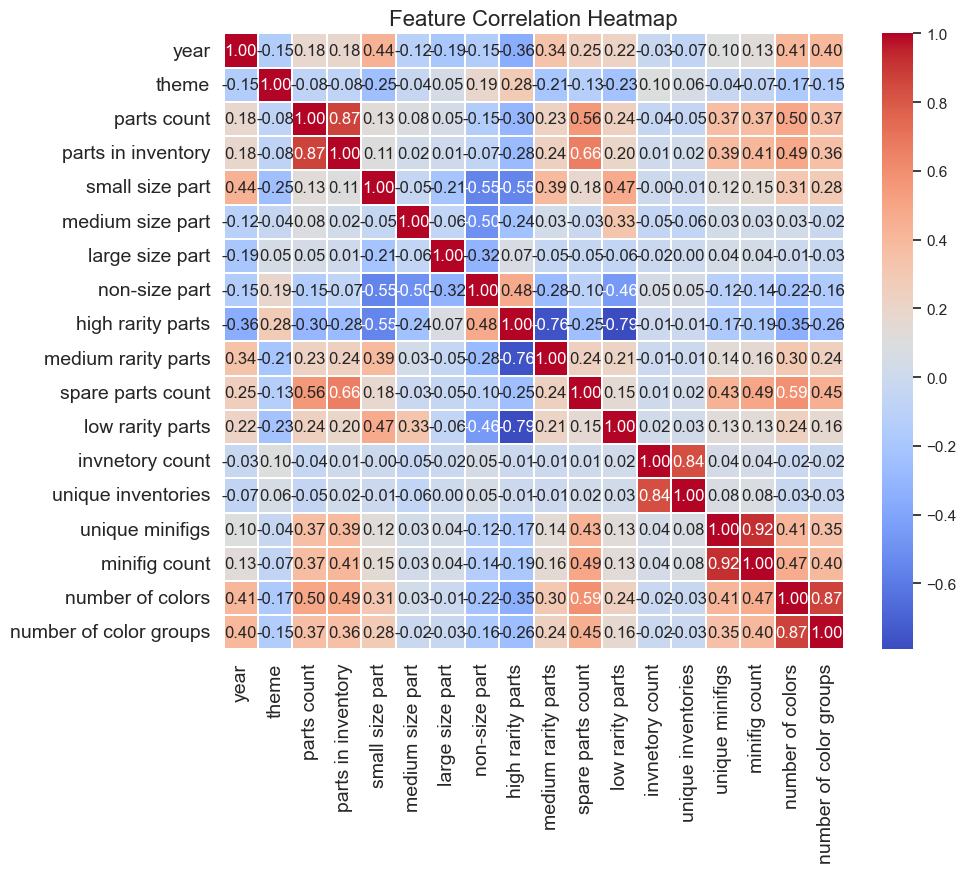

In [5]:
# Features

df_all[feature_names]
correlation_matrix = df_all[feature_names].corr()
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.2)


feature_names2 = ['year','theme','parts count','parts in inventory','small size part','medium size part','large size part','non-size part',
                  'high rarity parts','medium rarity parts','spare parts count','low rarity parts','invnetory count','unique inventories','unique minifigs',
                  'minifig count', 'number of colors','number of color groups']
ax = plt.gca()
#ax.set_yticks(range(len(feature_names2)))
ax.set_yticklabels(feature_names2)
ax.set_xticklabels(feature_names2)
plt.setp(ax.get_xticklabels(), fontsize=label_fontsize) 
plt.setp(ax.get_yticklabels(), fontsize=label_fontsize) 

plt.title('Feature Correlation Heatmap',fontsize = title_fontsize)
plt.show()


C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'decade']  = (truncated_data['year'] // 10) * 10
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['decade'] = truncated_data['decade'].astype(int)


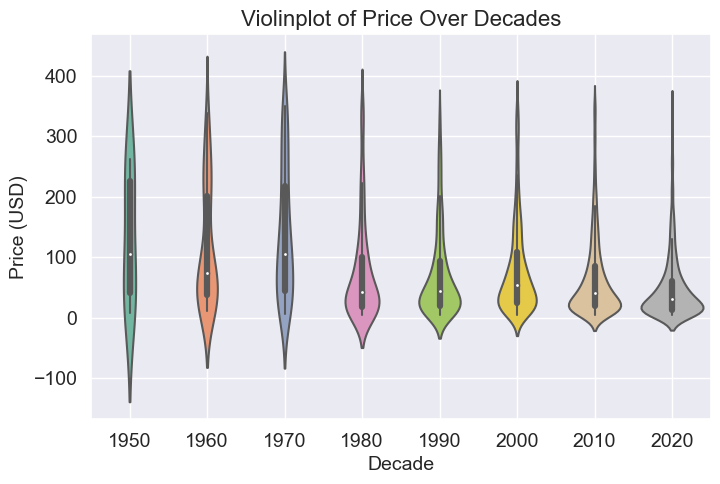

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['decade'] = truncated_data['decade'].astype(int)


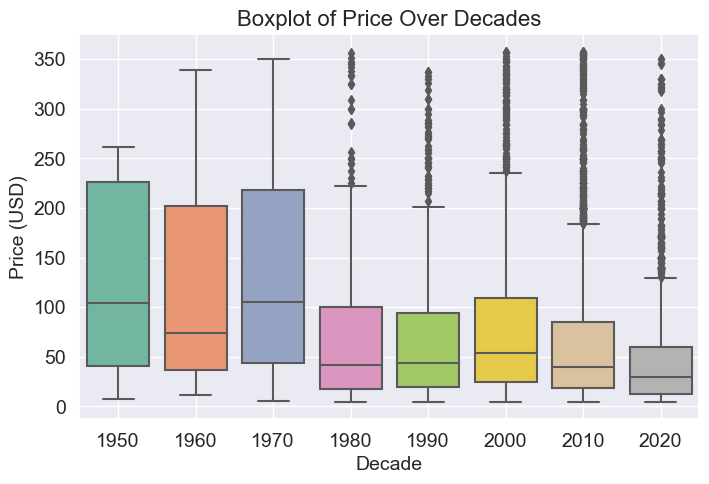

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)


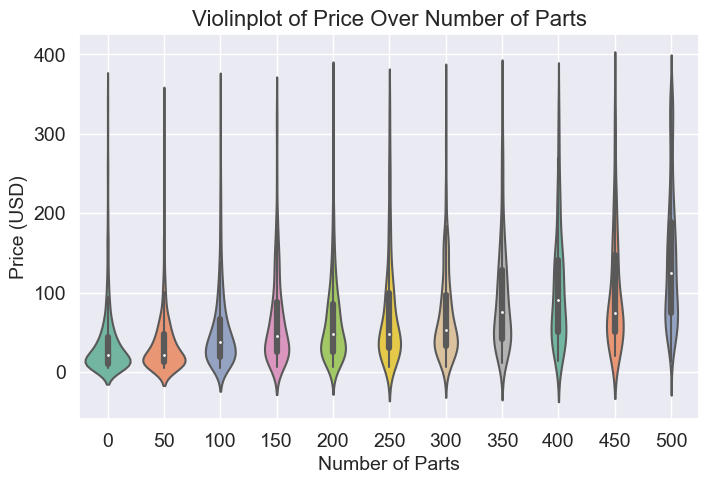

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)


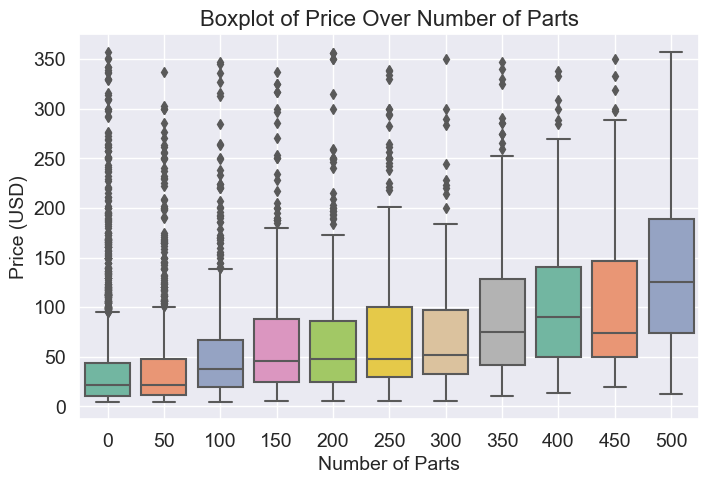

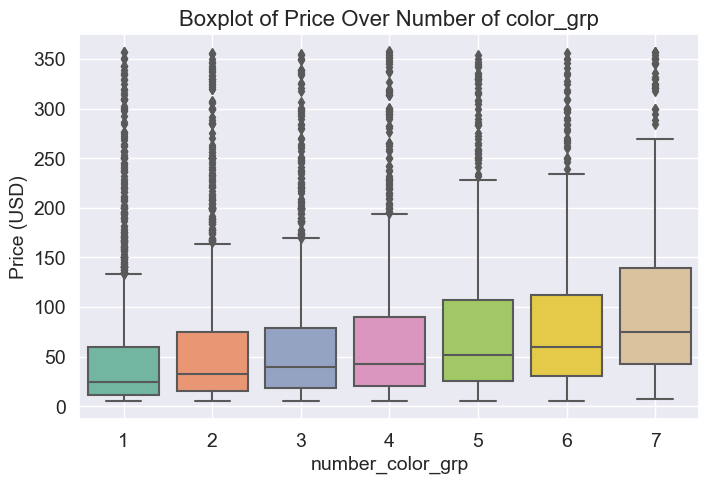

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\2261400799.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'colors']  = (truncated_data['number_colors'] // 5) * 5


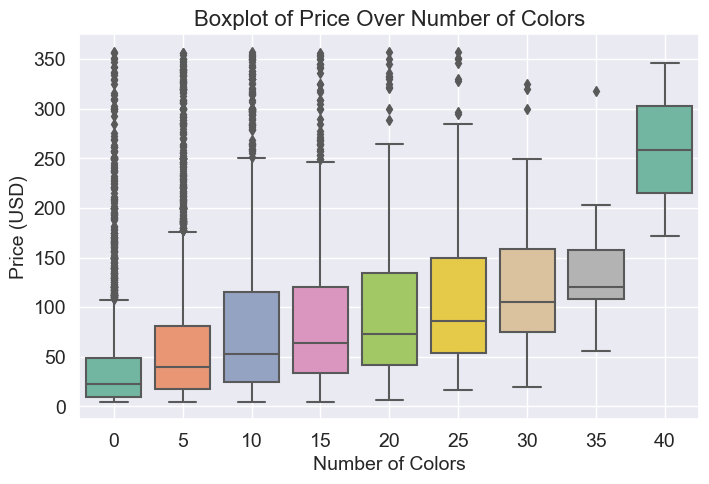

In [6]:
# truncate data with 5% and 95% quantile
price_min = df_all['price'].quantile(0.05)  
price_max = df_all['price'].quantile(0.95) 
truncated_data = df_all[(df_all['price'] >= price_min) & (df_all['price'] <= price_max)]
ylabel = 'Price (USD)'


if False:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='year', y='price', data=truncated_data, palette='Set2')
    plt.title('Scatter plot of Year vs. Price')
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.show()



truncated_data.loc[:, 'decade']  = (truncated_data['year'] // 10) * 10
truncated_data['decade'] = truncated_data['decade'].astype(int)
plt.figure(figsize=(8, 5))
sns.violinplot(data=truncated_data, x='decade', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Violinplot of Price Over Decades',fontsize = title_fontsize)
plt.xlabel('Decade')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()

truncated_data.loc[:, 'decade']  = (truncated_data['year'] // 10) * 10
truncated_data['decade'] = truncated_data['decade'].astype(int)
plt.figure(figsize=(8, 5))
sns.boxplot(data=truncated_data, x='decade', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Over Decades',fontsize = title_fontsize)
plt.xlabel('Decade')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()





truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
truncated_data.loc[truncated_data['num_parts_grp'] >= 500, 'num_parts_grp'] = 500
truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)
plt.figure(figsize=(8, 5))
sns.violinplot(data=truncated_data, x='num_parts_grp', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Violinplot of Price Over Number of Parts',fontsize = title_fontsize)
plt.xlabel('Number of Parts')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()

truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
truncated_data.loc[truncated_data['num_parts_grp'] >= 500, 'num_parts_grp'] = 500
truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)
plt.figure(figsize=(8, 5))
sns.boxplot(data=truncated_data, x='num_parts_grp', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Over Number of Parts',fontsize = title_fontsize)
plt.xlabel('Number of Parts')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(data=truncated_data, x='number_color_grp', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Over Number of color_grp',fontsize = title_fontsize)
plt.xlabel('number_color_grp')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()


truncated_data.loc[:, 'colors']  = (truncated_data['number_colors'] // 5) * 5
plt.figure(figsize=(8, 5))
sns.boxplot(data=truncated_data, x='colors', y='price', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Over Number of Colors',fontsize = title_fontsize)
plt.xlabel('Number of Colors')
plt.ylabel(ylabel)
plt.grid(True)  
plt.show()



In [7]:
df_msrp

set_num    msrp              theme_parent_name    year  theme_PPP  \
0      4548-1   41.99                          Train  1991.0   2.823525   
1      2304-1   14.99                          Duplo  1992.0   1.353364   
2      6323-1    6.99                           Town  1997.0   1.328960   
3      4519-1    9.99                          Train  1999.0   2.823525   
4      3732-1    4.99                    Bulk Bricks  2000.0   4.456478   
...       ...     ...                            ...     ...        ...   
4407  80047-1   74.99                     Monkie Kid  2023.0   0.230347   
4408  80048-1   79.99                     Monkie Kid  2023.0   0.230347   
4409  80049-1  189.99                     Monkie Kid  2023.0   0.230347   
4410  80110-1   89.99  Chinese Traditional Festivals  2023.0   0.221278   
4411  80111-1  129.99  Chinese Traditional Festivals  2022.0   0.221278   

      num_parts  parts_quantity  small_parts_quantity  medium_parts_quantity  \
0           3.0             5.0              0.000000               0.000000   
1           1.0             1.0              0.000000               0.000000   
2           2.0             2.0              0.000000               0.000000   
3           1.0             1.0              0.000000               0.000000   
4          24.0            12.0              0.000000               0.333333   
...         ...             ...                   ...                    ...   
4407      612.0           395.0              0.468354               0.172152   
4408      796.0           469.0              0.535181               0.140725   
4409     2371.0          1235.0              0.398272               0.243519   
4410      872.0           364.0              0.412399               0.221024   
4411     1655.0           862.0              0.487585               0.161400   

      large_parts_quantity  ...  unique_minifigs  num_minifigs  number_colors  \
0                 0.000000  ...              0.0           0.0              2   
1                 1.000000  ...              0.0           0.0              1   
2                 1.000000  ...              0.0           0.0              1   
3                 0.000000  ...              0.0           0.0              1   
4                 0.333333  ...              0.0           0.0              2   
...                    ...  ...              ...           ...            ...   
4407              0.086076  ...              4.0           4.0             18   
4408              0.068230  ...              5.0           5.0             20   
4409              0.122545  ...              9.0           7.0             35   
4410              0.150943  ...              0.0           0.0             22   
4411              0.103837  ...             18.0          18.0             27   

      number_color_grp     price  price_increase  price_increase_per_year  \
0                    2   60.0000        0.428912                 0.012997   
1                    1    7.0000       -0.533022                -0.016657   
2                    1   27.6200        2.951359                 0.109310   
3                    1   37.3279        2.736527                 0.109461   
4                    1   10.0000        1.004008                 0.041834   
...                ...       ...             ...                      ...   
4407                 6   80.1600        0.068943                 0.068943   
4408                 6   85.4300        0.068009                 0.068009   
4409                 7  203.2900        0.070004                 0.070004   
4410                 6   96.2000        0.069008                 0.069008   
4411                 7  138.8300        0.068005                 0.034003   

      theme_pi  theme_pipp   theme  
0     3.971359    0.181602  others  
1     0.313886    0.047596   Duplo  
2     3.080374    0.183468  others  
3     3.971359    0.181602  others  
4     1.827861    0.085942  others  
...        ...         .

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\402275979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['price_increase'] = truncated_data['price_increase'] * 100
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\402275979.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'decade'] = (truncated_data.loc[:,'year'] // 10) * 10
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\402275979.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

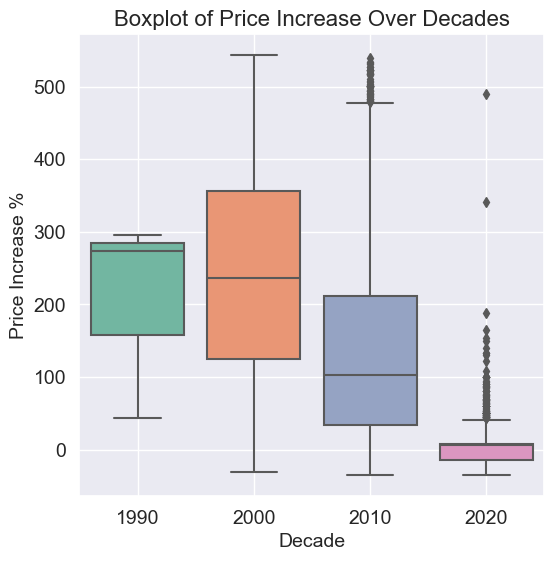

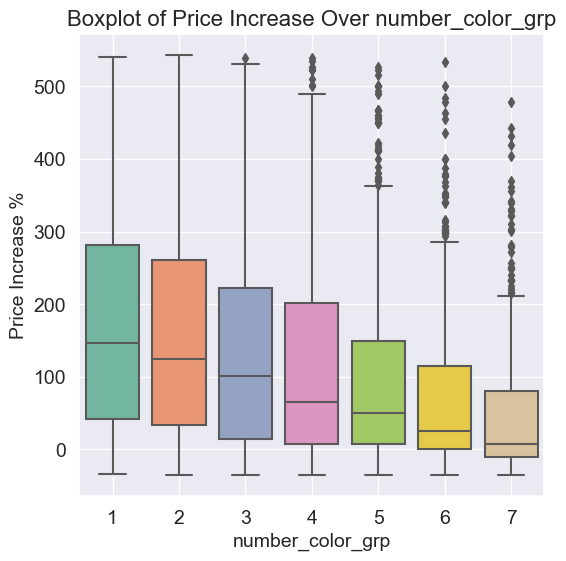

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\402275979.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\402275979.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)


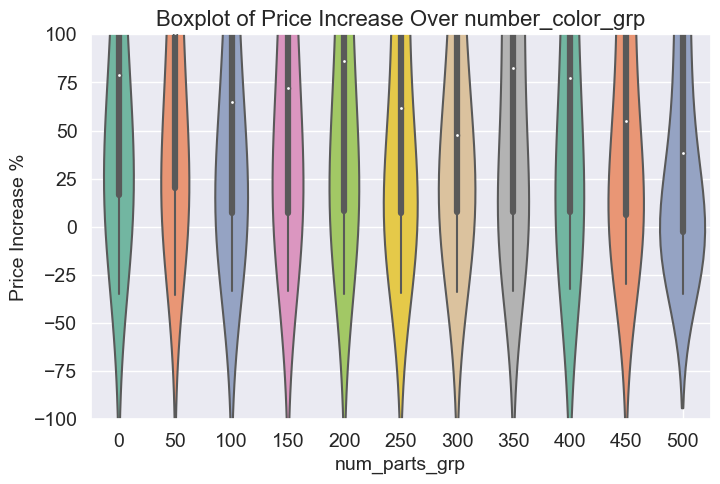

In [8]:
# price increase

# truncate data with 5% and 95% quantile
price_min = df_msrp['price_increase'].quantile(0.05)  
price_max = df_msrp['price_increase'].quantile(0.95)  
truncated_data = df_msrp[(df_msrp['price_increase'] >= price_min) & (df_msrp['price_increase'] <= price_max)]

truncated_data['price_increase'] = truncated_data['price_increase'] * 100
truncated_data.loc[:, 'decade'] = (truncated_data.loc[:,'year'] // 10) * 10
truncated_data['decade'] = truncated_data['decade'].astype(int)

plt.figure(figsize=(6, 6))
sns.boxplot(data=truncated_data, x='decade', y='price_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Increase Over Decades',fontsize = title_fontsize)
plt.xlabel('Decade')
plt.ylabel('Price Increase %')
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()



plt.figure(figsize=(6, 6))
sns.boxplot(data=truncated_data, x='number_color_grp', y='price_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Increase Over number_color_grp',fontsize = title_fontsize)
plt.xlabel('number_color_grp')
plt.ylabel('Price Increase %')
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()



truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
truncated_data.loc[truncated_data['num_parts_grp'] >= 500, 'num_parts_grp'] = 500
truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)
plt.figure(figsize=(8, 5))
sns.violinplot(data=truncated_data, x='num_parts_grp', y='price_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Boxplot of Price Increase Over number_color_grp',fontsize = title_fontsize)
plt.xlabel('num_parts_grp')
plt.ylim(-100,100)
plt.ylabel('Price Increase %')
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()



C:\Users\niels\AppData\Local\Temp\ipykernel_3672\1291290851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['price_annual_increase'] = truncated_data['price_increase_per_year'] * 100
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\1291290851.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'decade'] = (truncated_data.loc[:,'year'] // 10) * 10
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\1291290851.py:15: SettingWithCopyWarning: 
A value is trying to be set 

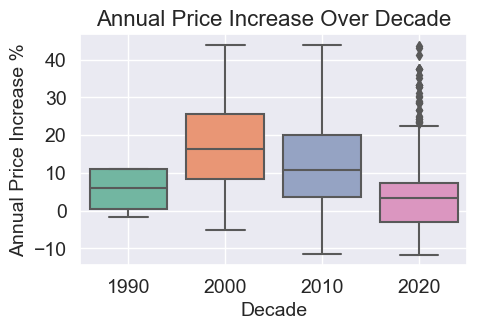

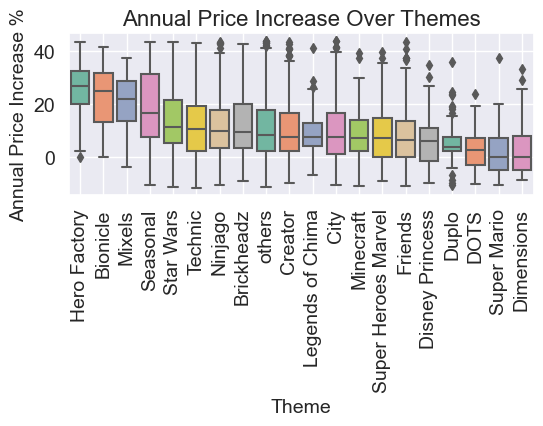

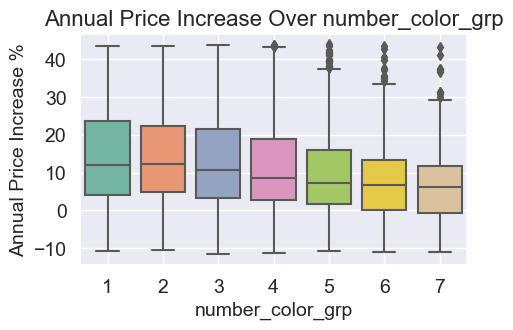

C:\Users\niels\AppData\Local\Temp\ipykernel_3672\1291290851.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
C:\Users\niels\AppData\Local\Temp\ipykernel_3672\1291290851.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)


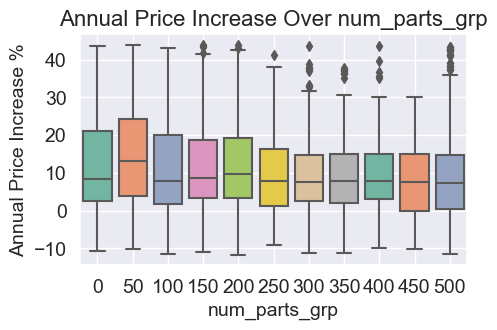

In [9]:
# price increase


title = 'Annual Price Increase Over '
ylabel = 'Annual Price Increase %'

# truncate data with 5% and 95% quantile
price_min = df_msrp['price_increase_per_year'].quantile(0.05)  
price_max = df_msrp['price_increase_per_year'].quantile(0.95)  
truncated_data = df_msrp[(df_msrp['price_increase_per_year'] >= price_min) & (df_msrp['price_increase_per_year'] <= price_max)]


truncated_data['price_annual_increase'] = truncated_data['price_increase_per_year'] * 100
truncated_data.loc[:, 'decade'] = (truncated_data.loc[:,'year'] // 10) * 10
truncated_data['decade'] = truncated_data['decade'].astype(int)
plt.figure(figsize=(5,3))
sns.boxplot(data=truncated_data, x='decade', y='price_annual_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)

plt.title(title + 'Decade',fontsize = title_fontsize)
plt.xlabel('Decade')
plt.ylabel(ylabel)
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()



order = list(truncated_data[truncated_data['theme']!= 'Gear'].groupby('theme')['price_increase_per_year'].median().sort_values(ascending = False).index)
plt.figure(figsize=(6,2.1))
sns.boxplot(data=truncated_data[truncated_data['theme']!= 'Gear'], x='theme', y='price_annual_increase',order = order, palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)

plt.title(title + 'Themes',fontsize = title_fontsize)
#plt.ylim(-0.5,0.8)
plt.xlabel('Theme')
plt.ylabel(ylabel)
plt.xticks(rotation=90)  
plt.grid(True)  
plt.show()



plt.figure(figsize=(5,3))
sns.boxplot(data=truncated_data, x='number_color_grp', y='price_annual_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
    
plt.title(title + 'number_color_grp',fontsize = title_fontsize)
plt.xlabel('number_color_grp')
plt.ylabel(ylabel)
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()


truncated_data.loc[:, 'num_parts_grp']  = (truncated_data['num_parts'] // 50) * 50
truncated_data.loc[truncated_data['num_parts_grp'] >= 500, 'num_parts_grp'] = 500
truncated_data['num_parts_grp'] = truncated_data['num_parts_grp'].astype(int)
plt.figure(figsize=(5,3))
sns.boxplot(data=truncated_data, x='num_parts_grp', y='price_annual_increase', palette='Set2')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
    
plt.title(title + 'num_parts_grp',fontsize = title_fontsize)
plt.xlabel('num_parts_grp')
plt.ylabel(ylabel)
#plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()


In [10]:
from scipy import stats


feature_groups = [group[1] for group in df_msrp.groupby('theme')['price_increase_per_year']]
f_statistic, p_value = stats.f_oneway(*feature_groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)







F-statistic: 12.325516857054877
p-value: 1.011688131662502e-39


year's p-value: 7.101070777185139e-83
theme_PPP's p-value: 0.058437919960323416
num_parts's p-value: 1.2664156087892642e-239
parts_quantity's p-value: 1.5680942177924367e-173
small_parts_quantity's p-value: 2.8200187024004438e-09
medium_parts_quantity's p-value: 1.1560450520006287e-11
large_parts_quantity's p-value: 3.7290311331158285e-14
none_size_parts_quantity's p-value: 0.029953220630365138
rare_part's p-value: 1.0205760430764996e-10
moderate_part's p-value: 0.04757073773049328
spare_parts_quantity's p-value: 2.17347960491804e-19
common_part's p-value: 1.8906531881720684e-15
inv_quantity's p-value: 0.6401027058117696
inv_unique's p-value: 0.16459601721493852
unique_minifigs's p-value: 8.287159475796249e-60
num_minifigs's p-value: 6.485809771452422e-58
number_colors's p-value: 7.979669690056201e-20
number_color_grp's p-value: 0.00012099146958822935


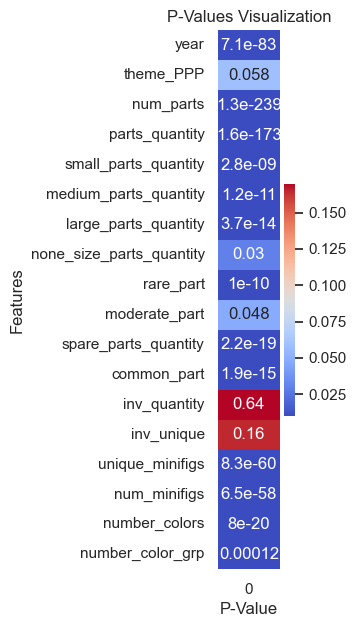

In [11]:
p_values = {}
for feature_name in feature_names:
    feature = df_all[feature_name]
    target = df_all['price']

    pearson_corr, p_value = stats.pearsonr(feature, target)
    print(f"{feature_name}'s p-value:", p_value)
    p_values[feature_name] = [p_value]

p_values_df = pd.DataFrame( p_values )



# visualization
plt.figure(figsize=(1,7))
sns.heatmap(p_values_df.T, annot=True, fmt=".2g", cmap="coolwarm", vmax=0.17,vmin = 0.01)
plt.title('P-Values Visualization')
plt.xlabel('P-Value')
plt.ylabel('Features')
plt.show()


In [12]:
#### End of Feature part

In [13]:
# models

def linear_regression(df, feature_names, target=['price'], test_size=0.2, random_state=2024):

    X = df[feature_names]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # ColumnTransformer for categorical_features
    #categorical_features = ['theme_parent_name']
    #preprocessor = ColumnTransformer( transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

    # modelling
    model = Pipeline(steps=[
                            #('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)

    # result
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    return (r2,np.sqrt(mse)),model



def ridge_model(df, feature_names, target=['price'], test_size=0.2, random_state=2024):

    X = df[feature_names]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # ColumnTransformer for categorical_features
    #categorical_features = ['theme_parent_name']
    #preprocessor = ColumnTransformer( transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    
    
    param_grid = {'alpha': [1,10,50,100,500]}
    # modelling
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, cv=5)

    # 初始化Ridge回归模型
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # 使用最佳模型进行预测
    y_pred = best_model.predict(X)

    # 计算并打印 R² 值
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print("R-squared Score:", r2)
    print("Root Mean Squared Error:", np.sqrt(mse))
    # 打印最佳参数
    print("Best Parameters:", grid_search.best_params_)
    return (r2,np.sqrt(mse)),best_model


def xgb_model(df, feature_names, target=['price'], test_size=0.2, random_state=2024):

    X = df[feature_names]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # ColumnTransformer for categorical_features
    #categorical_features = ['theme_parent_name']
    #preprocessor = ColumnTransformer( transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

    # modelling
    xgb_ = xgb.XGBRegressor()
    model = Pipeline(steps=[
                            #('preprocessor', preprocessor),
                            ('regressor', xgb_)])
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)

    # result
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    return (r2,np.sqrt(mse)),model


def gbdt_model(df, feature_names, target='price', test_size=0.2, random_state=2024):

    X = df[feature_names]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # ColumnTransformer for categorical_features
    #categorical_features = ['theme_parent_name']
    #preprocessor = ColumnTransformer( transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

    # modelling
    gbdt = GradientBoostingRegressor()
    model = Pipeline(steps=[
                            #('preprocessor', preprocessor),
                            ('regressor', gbdt )])
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)

    # result
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    return r2, model




def xgb_model_k_fold(df, feature_names, target=['price'], random_state=2024, k=5,params={}):

    X = df[feature_names]
    y = df[target]

    # k-fold
    k_fold = KFold(n_splits=k, shuffle=True, random_state=random_state)

    xgb_model = xgb.XGBRegressor(**params)
    r2_scores = []
    mses = []

    # k-fold validation
    for train_index, test_index in k_fold.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        xgb_pipeline = Pipeline(steps=[ ('regressor', xgb_model) ])
        xgb_pipeline.fit(X_train_fold, y_train_fold)

        # preidiction
        y_pred_fold = xgb_pipeline.predict(X_test_fold)

        r2_fold = r2_score(y_test_fold, y_pred_fold)
        r2_scores.append(r2_fold)
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        mses.append(mse_fold)

    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(np.sqrt(mses))
    
    print("Mean R-squared Score (k-fold CV):", mean_r2)
    print("r2_scores:", r2_scores)
    return mean_r2



def xgb_model_random_search(df, feature_names, target=['price'], random_state=2024, k=5, n_iter=3,scoring='r2'):

    X = df[feature_names]
    y = df[target]
    xgb_model = xgb.XGBRegressor()
    #random search params

    param_dist = {
        'regressor__n_estimators': [100, 200, 300, 400, 500], 
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  
        'regressor__max_depth': [3, 4, 5, 6, 7],  
        'regressor__min_child_weight': [1, 2, 3, 4, 5], 
        'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  
        'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  
        'regressor__reg_alpha': [0.1, 0.5, 1.0],  
        'regressor__reg_lambda': [0.1, 0.5, 1.0],  
        'regressor__gamma': [0, 0.1, 0.5, 1.0] 
    }

    # ranndom search and k-fold model
    k_fold = KFold(n_splits=k, shuffle=True, random_state=random_state)
    xgb_pipeline = Pipeline(steps=[('regressor', xgb_model)])
    random_search = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_dist, 
                                       n_iter=n_iter, cv=k_fold
                                       , scoring=scoring
                                       , random_state=random_state)
    random_search.fit(X, y)

    print("Best Parameters:", random_search.best_params_)

    best_model = random_search.best_estimator_
    cv_r2_scores = cross_val_score(best_model, X, y, cv=k_fold, scoring='r2')
    mean_cv_r2 = np.mean(cv_r2_scores)
    print("Mean R-squared Score (k-fold CV):", mean_cv_r2)
    print(cv_r2_scores)
    print('\n')
    return random_search.best_params_, cv_r2_scores, random_search.cv_results_, best_model



In [14]:
%%time
# compare models with default param
for model in ['linear_regression','ridge_model','gbdt_model','xgb_model']: #
    print('\n'+f'model:{model}')
    for i in [123,456,789]:
        exec( model + r'(df1, feature_names,random_state = i)' )
        
for model in ['linear_regression','ridge_model','gbdt_model','xgb_model']:
    print('\n'+f'model:{model}')
    for i in [123,456,789]:
        exec( model + r'(df_all, feature_names,random_state = i)' )


model:linear_regression
Root Mean Squared Error: 119.76634108118421
R-squared Score: 0.24959288487856135
Root Mean Squared Error: 97.83959078558122
R-squared Score: 0.38416200320411165
Root Mean Squared Error: 99.85410804506348
R-squared Score: 0.3820201468553215

model:ridge_model
R-squared Score: 0.25611144316249335
Root Mean Squared Error: 126.40815150151627
Best Parameters: {'alpha': 100}
R-squared Score: 0.2541948431208544
Root Mean Squared Error: 126.57088959891377
Best Parameters: {'alpha': 500}
R-squared Score: 0.25414269532372824
Root Mean Squared Error: 126.575314533254
Best Parameters: {'alpha': 500}

model:gbdt_model
Root Mean Squared Error: 133.40689890944708
R-squared Score: 0.06892651843055764
Root Mean Squared Error: 78.06192727985919
R-squared Score: 0.6079731935296127
Root Mean Squared Error: 100.1144511267791
R-squared Score: 0.3787935091666824

model:xgb_model
Root Mean Squared Error: 181.01860700291613
R-squared Score: -0.714248651849207
Root Mean Squared Error: 8

In [15]:
%%time

# k-fold xgb

random_state=2024
xgb_model_k_fold(df1, feature_names,random_state=random_state)
xgb_model_k_fold(df2, feature_names,random_state=random_state)
xgb_model_k_fold(df3, feature_names,random_state=random_state)

df = pd.concat([df1[feature_names + ['price']], df2[feature_names + ['price']], df3[feature_names + ['price']]])
xgb_model_k_fold(df, feature_names,random_state=random_state)


temp = '''
params = {
    'n_estimators': 30,  
    'max_depth': 8,       
    'learning_rate': 0.228, 
    'objective': 'reg:squarederror'
}
xgb_model_k_fold(df1, feature_names,params=params,random_state=random_state)
xgb_model_k_fold(df2, feature_names,params=params,random_state=random_state)
xgb_model_k_fold(df3, feature_names,params=params,random_state=random_state)
xgb_model_k_fold(df, feature_names,params=params,random_state=random_state)
'''

Mean R-squared Score (k-fold CV): 0.3650919621332063
r2_scores: [0.5834740874579492, 0.5610525382467775, 0.24151231453859812, 0.15904500694169244, 0.2803758634810146]
Mean R-squared Score (k-fold CV): 0.4045631028731472
r2_scores: [0.46181975994924995, -0.01695528163081228, 0.4346927159335323, 0.5969213512790783, 0.5463369688346875]
Mean R-squared Score (k-fold CV): 0.2993803483201165
r2_scores: [0.26511053021434616, 0.29188026116420906, 0.16633380361152794, 0.5010944344156582, 0.2724827121948412]
Mean R-squared Score (k-fold CV): 0.2987079894755521
r2_scores: [0.21387800827747838, 0.3910774662020029, 0.3581545182341157, 0.35987867934759266, 0.17055127531657088]
CPU times: total: 47.9 s
Wall time: 6.68 s


In [16]:

# results for different models


dict_df = {'Data_kaggle':df1, 'Data_mendeley':df2, 'Data_brickeconomy':df3, 'Data_combined':df_all}



model_results_linear = {}
model_results_linear_rmse = {}


for i,df in dict_df.items():  
    print('----')
    t=[]
    tt=[]
    for random_state in [123,456,789,2023,2024]:
        for test_size in [0.2,0.25,0.3]:
            temp = linear_regression(df, feature_names,random_state=random_state,test_size=test_size)[0]
            t.append( temp[0] )
            tt.append(temp[1])
    model_results_linear[i] = t 
    model_results_linear_rmse[i] = tt


model_results_ridge = {}
model_results_ridge_rmse = {}
for i,df in dict_df.items():  
    print('----')
    t=[]
    tt=[]
    for random_state in [123,456,789,2023,2024]:
        for test_size in [0.2,0.25,0.3]:
            temp = ridge_model(df, feature_names,random_state=random_state,test_size=test_size)[0]
            t.append( temp[0] )
            tt.append(temp[1])
    model_results_ridge[i] = t 
    model_results_ridge_rmse[i] = tt


model_results_xgb = {}
for i,df in dict_df.items():  
    print('----')
    t=[]
    for random_state in [123,456,789,2023,2024]:
        t.append( xgb_model_k_fold(df, feature_names,random_state=random_state) )
    model_results_xgb[i] = t 


----
Root Mean Squared Error: 119.76634108118421
R-squared Score: 0.24959288487856135
Root Mean Squared Error: 111.25228598878485
R-squared Score: 0.277761623040531
Root Mean Squared Error: 106.59279674848084
R-squared Score: 0.29742309699356484
Root Mean Squared Error: 97.83959078558122
R-squared Score: 0.38416200320411165
Root Mean Squared Error: 185.38804309203815
R-squared Score: 0.14098725658926203
Root Mean Squared Error: 172.16879081072577
R-squared Score: 0.14620344147727715
Root Mean Squared Error: 99.85410804506348
R-squared Score: 0.3820201468553215
Root Mean Squared Error: 102.21465977496132
R-squared Score: 0.3704893302955785
Root Mean Squared Error: 104.6534637768892
R-squared Score: 0.3572810784919601
Root Mean Squared Error: 114.6602511269412
R-squared Score: 0.23260490001989798
Root Mean Squared Error: 112.18028683615951
R-squared Score: 0.26095034204987755
Root Mean Squared Error: 117.02336443965117
R-squared Score: 0.26795484447377693
Root Mean Squared Error: 86.8266

In [17]:
temp = []
for key, value in dict_df.items():
    temp.append( xgb_model_random_search(value, feature_names, target=['price'],random_state = 2024,k=5,n_iter=10,scoring = 'neg_mean_squared_error') )
xgb_models = temp[:]


Best Parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 1.0, 'regressor__n_estimators': 500, 'regressor__min_child_weight': 4, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Mean R-squared Score (k-fold CV): 0.49065093047466224
[0.60173961 0.56640295 0.5250292  0.1851565  0.57492639]


Best Parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 1.0, 'regressor__n_estimators': 500, 'regressor__min_child_weight': 4, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.8}
Mean R-squared Score (k-fold CV): 0.5557872614639805
[0.56110566 0.57082863 0.50723562 0.57334918 0.56641722]


Best Parameters: {'regressor__subsample': 0.7, 'regressor__reg_lambda': 1.0, 'regressor__reg_alpha': 1.0, 'regressor__n_estimators': 500, 'regressor__min_child_weight': 5, 'regressor__max_dep

In [18]:
# models performance in df_all

key = 'Data_combined'
value = dict_df[key]
temp = {}
tt = []
for i in range(3):
    t=[]
    for random_state in [123,456,789,2023,2024]:
        for n_splits in [4]:
            k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            X = value[feature_names]
            y = value['price']
            t.append( np.mean( cross_val_score(xgb_models[i][-1], X, y, cv=k_fold, scoring='r2') ) )
    temp[key] = t[:]
    print(t)
    tt.append(t)
    i += 1

[0.37033219699791964, 0.3726271357154862, 0.38515346132098705, 0.3795364152536193, 0.34543414032704134]
[0.37033219699791964, 0.3726271357154862, 0.38515346132098705, 0.3795364152536193, 0.34543414032704134]
[0.34457662729939187, 0.33172368223460025, 0.35228695795246073, 0.34333724087080375, 0.31801895311185235]


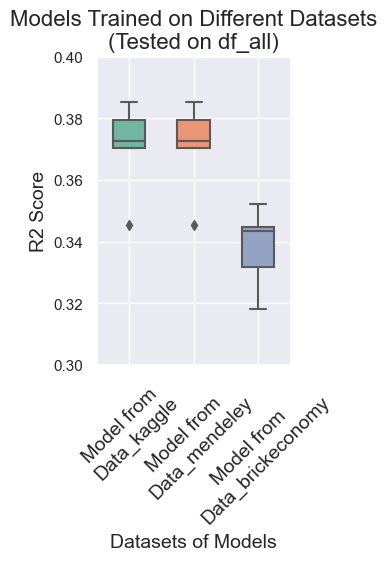

In [19]:
sns_box_plot({
'''Model from 
Data_kaggle''':tt[0],
'''Model from 
Data_mendeley''':tt[1],
'''Model from 
Data_brickeconomy''':tt[2]
},xlabel = 'Datasets of Models',ylim = (0.3,0.4)
, title = 'Models Trained on Different Datasets\n(Tested on df_all)'
,figsize = (2.5,4), rotation = 45)

<Figure size 600x600 with 0 Axes>

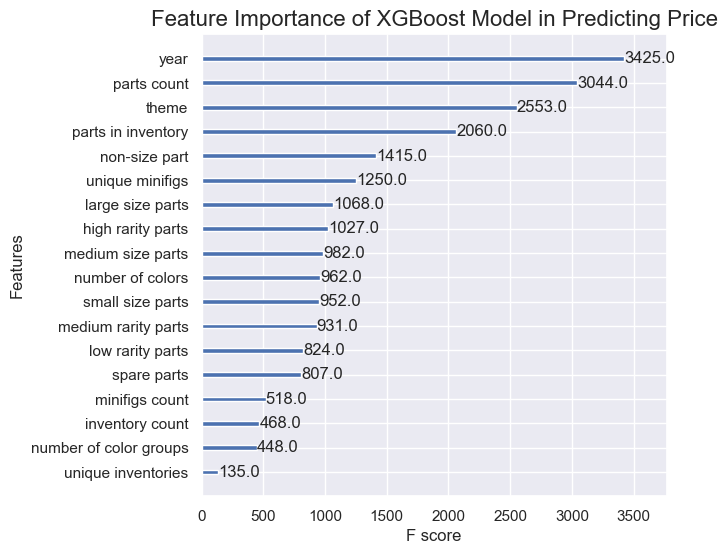

In [20]:
plt.rcParams['figure.figsize'] = [6, 6] 
my_xgb_model = xgb_models[0][-1].named_steps['regressor']
booster = my_xgb_model.get_booster()
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
xgb.plot_importance(booster)
plt.title('Feature Importance of XGBoost Model in Predicting Price',fontsize=title_fontsize)

plt.gca().set_yticklabels(['year','parts count','theme','parts in inventory','non-size part','unique minifigs','large size parts','high rarity parts','medium size parts',
                           'number of colors','small size parts','medium rarity parts','low rarity parts','spare parts','minifigs count','inventory count',
                           'number of color groups','unique inventories'][::-1])
plt.show()


R-squared Score: 0.21126985069430304
Root Mean Squared Error: 209.66388946495064
Best Parameters: {'alpha': 50}


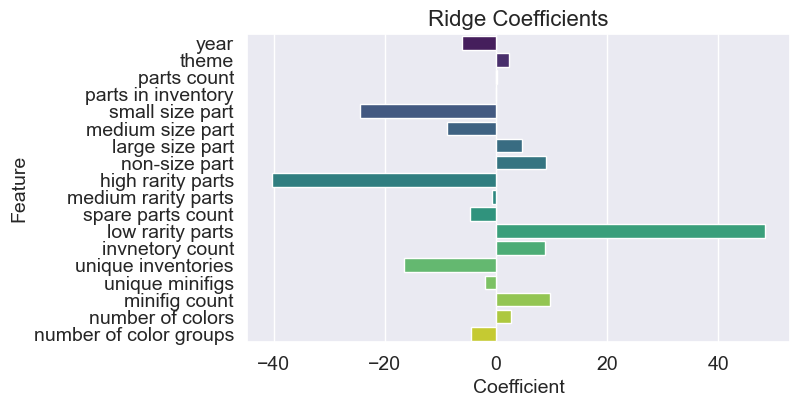

In [21]:

ridge = ridge_model(df_all, feature_names)[-1] 


coefficients = ridge.coef_
coefficients_df = pd.DataFrame({'Feature': feature_names2, 'Coefficient': coefficients[0]})

plt.figure(figsize=(7, 4))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='viridis')
plt.xlabel('Coefficient', fontsize=label_fontsize)
plt.ylabel('Feature', fontsize=label_fontsize)
plt.title('Ridge Coefficients', fontsize=title_fontsize)
plt.xticks(fontsize=label_fontsize)
plt.yticks(fontsize=label_fontsize)
plt.show()


In [22]:
# R2 of best model in random search
i=0
temp = {}
for key, value in dict_df.items():
    t=[]
    for random_state in [123,456,789,2023,2024]:
        for n_splits in [4,5]:
            k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            X = value[feature_names]
            y = value['price']
            t.append( np.mean( cross_val_score(xgb_models[i][-1], X, y, cv=k_fold, scoring='r2') ) )
    temp[key] = t[:]
    print(t)
    i += 1


model_results_xgb_kfold_search = temp.copy()

[0.40448150098030805, 0.41719036535627474, 0.43231520563911097, 0.46180742875986036, 0.40747167054407946, 0.46198024852765984, 0.37053388226593154, 0.4396313018215947, 0.45151784074417334, 0.49065093047466224]
[0.5960526113485523, 0.5796731035037, 0.6179579970806903, 0.6015137973602717, 0.5865099820323235, 0.5888937972517793, 0.5920796692242354, 0.6092433331575888, 0.5739462937619765, 0.5557872614639805]
[0.2560658132201014, 0.22893037994540427, 0.19861544889458982, 0.2281817403078473, 0.2420641745492747, 0.2367432196408518, 0.2913728914837863, 0.2749671441386238, 0.2582615578591513, 0.32315533576866107]
[0.37033219699791964, 0.38580727369683354, 0.3726271357154862, 0.3896682415716411, 0.38515346132098705, 0.387304468256611, 0.3795364152536193, 0.3692159813540893, 0.34543414032704134, 0.3686913136038208]


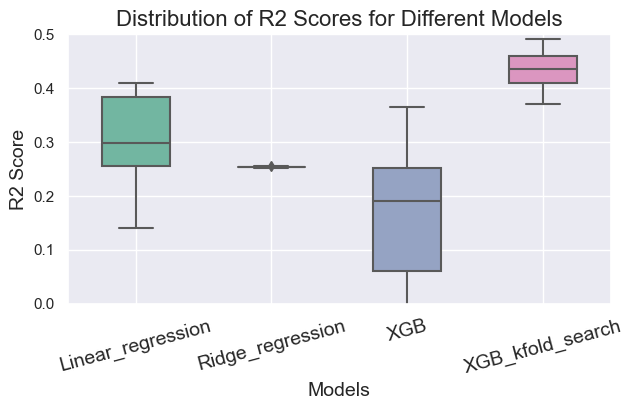

In [23]:
_ = 'Data_kaggle'
df={'Linear_regression':model_results_linear[_],
    'Ridge_regression':model_results_ridge[_],
    'XGB':model_results_xgb[_],
    'XGB_kfold_search':model_results_xgb_kfold_search[_]}
sns_box_plot(df,title = 'Distribution of R2 Scores for Different Models', xlabel = 'Models',figsize = (7,3.5),ylim = (0,0.5),rotation = 15)

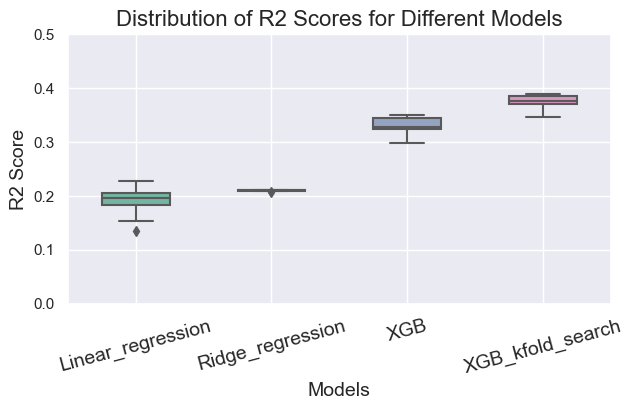

In [24]:
_ = 'Data_combined'
df={'Linear_regression':model_results_linear[_],
    'Ridge_regression':model_results_ridge[_],
    'XGB':model_results_xgb[_],
    'XGB_kfold_search':model_results_xgb_kfold_search[_]}
sns_box_plot(df,title = 'Distribution of R2 Scores for Different Models', xlabel = 'Models',figsize = (7,3.5),ylim = (0,0.5),rotation = 15)

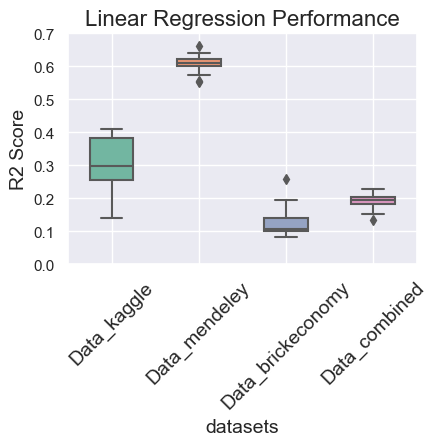

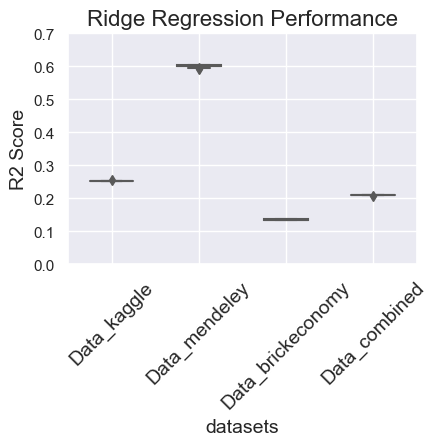

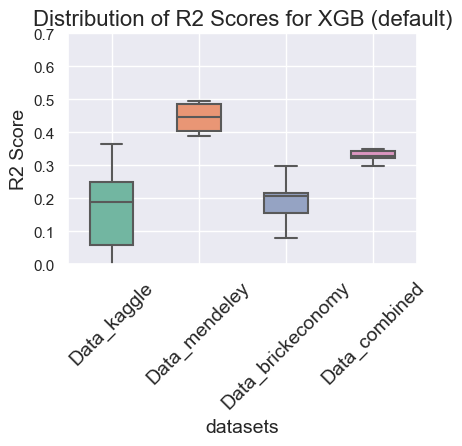

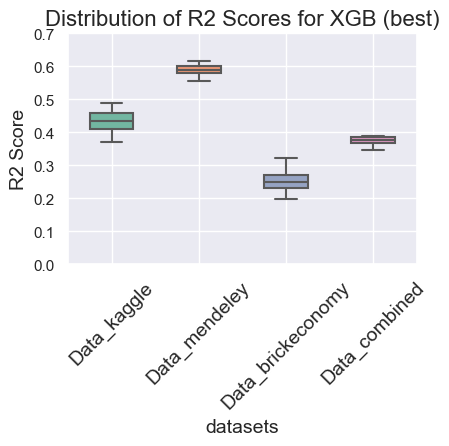

In [25]:
sns_box_plot(model_results_linear,xlabel = 'datasets', title='Linear Regression Performance'
             ,rotation = 45,figsize=(4.5,3),ylim=(0,0.7))
sns_box_plot(model_results_ridge,xlabel = 'datasets', title='Ridge Regression Performance'
             ,rotation = 45,figsize=(4.5,3),ylim=(0,0.7))
sns_box_plot(model_results_xgb,xlabel = 'datasets', title='Distribution of R2 Scores for XGB (default)'
             ,rotation = 45,figsize=(4.5,3),ylim=(0,0.7))
sns_box_plot(model_results_xgb_kfold_search,xlabel = 'datasets', title='Distribution of R2 Scores for XGB (best)'
             ,rotation = 45,figsize=(4.5,3),ylim=(0,0.7))

In [26]:
# df_msrp  price increase
feature_msrp = feature_names
for model in ['linear_regression','ridge_model','xgb_model']: #ridge_model  xgb_model_k_fold
    print('\n'+f'model:{model}')
    for i in [2024]: #[123,456,789,2023,2024]:
        exec( model + r"(df_msrp, feature_names + ['theme_pi', 'theme_pipp'],random_state = i,target = 'price_increase')" )
#xgb_model_k_fold(df_msrp,feature_names,target = ['price_increase'])


model:linear_regression
Root Mean Squared Error: 1.6240949603488872
R-squared Score: 0.42983280171391447

model:ridge_model
R-squared Score: 0.24868720643665831
Root Mean Squared Error: 3.120033754854361
Best Parameters: {'alpha': 500}

model:xgb_model
Root Mean Squared Error: 1.6469019977089936
R-squared Score: 0.41370673673151426


In [27]:
# df_msrp  price increase
for model in ['linear_regression','ridge_model','xgb_model']: #ridge_model  xgb_model_k_fold
    print('\n'+f'model:{model}')
    for i in [123,456,789,2023,2024]:
        exec( model + r"(df_msrp, feature_names + ['theme_pi', 'theme_pipp'],random_state = i,target = 'price_increase_per_year')" )
#xgb_model_k_fold(df_msrp,feature_names,target = ['price_increase'])


model:linear_regression
Root Mean Squared Error: 0.1648296223465617
R-squared Score: 0.27412014512408156
Root Mean Squared Error: 0.4483644779484168
R-squared Score: 0.14450020896924787
Root Mean Squared Error: 0.17141933207730178
R-squared Score: 0.08020818781452954
Root Mean Squared Error: 0.16207031624647736
R-squared Score: 0.08285812473860532
Root Mean Squared Error: 0.18782204384644163
R-squared Score: 0.24144584652883938

model:ridge_model
R-squared Score: 0.22154198478016218
Root Mean Squared Error: 0.24858545458394268
Best Parameters: {'alpha': 1}
R-squared Score: 0.20949027407743015
Root Mean Squared Error: 0.2505023040672618
Best Parameters: {'alpha': 1}
R-squared Score: 0.21882669029068103
Root Mean Squared Error: 0.24901861548281592
Best Parameters: {'alpha': 1}
R-squared Score: 0.22010533497189577
Root Mean Squared Error: 0.24881473196239634
Best Parameters: {'alpha': 1}
R-squared Score: 0.2226226660950088
Root Mean Squared Error: 0.24841284735930752
Best Parameters: {'a

In [28]:
# xgb_model for price_increase

#temp = df_msrp.copy() 
#temp['year'] =2024- temp['year']
temp_model = xgb_model_random_search(df_msrp, feature_names + ['theme_pi', 'theme_pipp'],random_state = 2024,target = 'price_increase',k=5, n_iter=10)[-1]
temp_model = temp_model.named_steps['regressor']
booster2 = temp_model.get_booster()

Best Parameters: {'regressor__subsample': 0.9, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 1.0}
Mean R-squared Score (k-fold CV): 0.4494472612952897
[0.49177871 0.13290153 0.52740754 0.57155308 0.52359544]




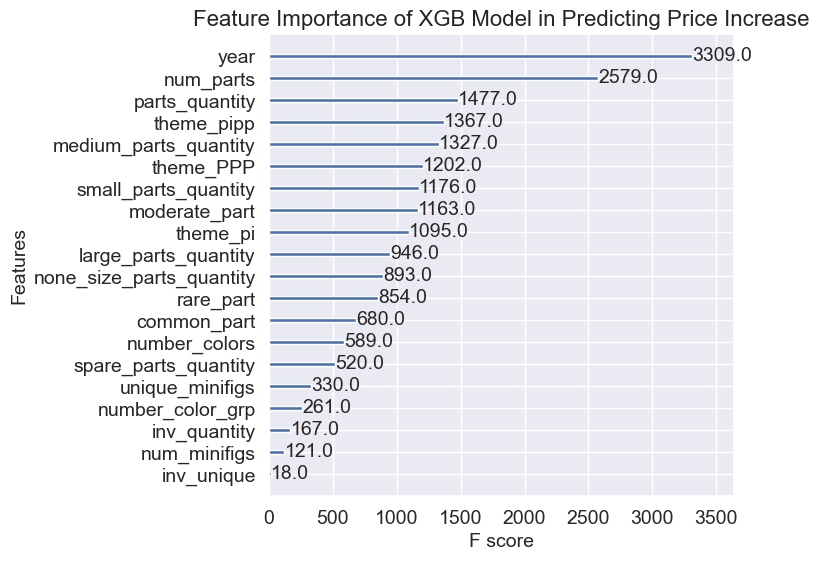

In [29]:
plt.rcParams['figure.figsize'] = [6, 6] 
xgb.plot_importance(booster2)

fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Feature Importance of XGB Model in Predicting Price Increase',fontsize = title_fontsize)
plt.show()

In [30]:
# xgb_model for price_increase_per_year

temp_model = xgb_model_random_search(df_msrp, feature_names + ['theme_pi', 'theme_pipp'],random_state = 2024,target = 'price_increase_per_year',k=5, n_iter=10)[-1]
temp_model = temp_model.named_steps['regressor']
price_increaes_model = temp_model
booster3 = temp_model.get_booster()

Best Parameters: {'regressor__subsample': 0.9, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 1.0}
Mean R-squared Score (k-fold CV): 0.2878981084376698
[0.29402079 0.134899   0.40094383 0.22277689 0.38685005]




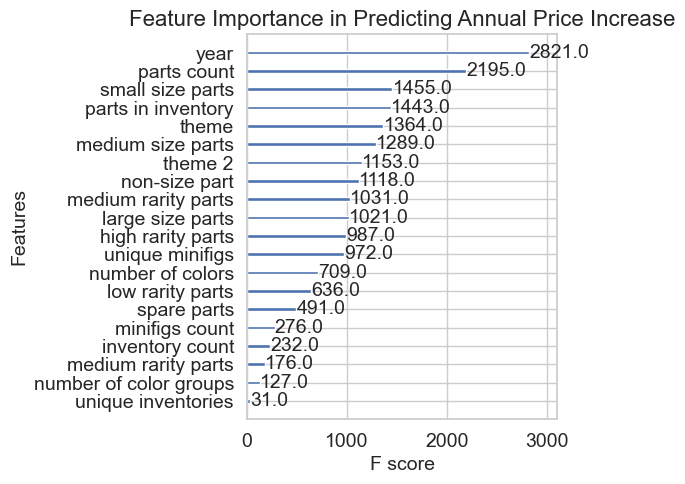

In [31]:
plt.rcParams['figure.figsize'] = [4,5] 
sns.set_style("whitegrid")
xgb.plot_importance(booster3)
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Feature Importance in Predicting Annual Price Increase',fontsize = title_fontsize)
plt.gca().set_yticklabels(['year','parts count','small size parts','parts in inventory','theme','medium size parts','theme 2', 'non-size part',
                           'medium rarity parts','large size parts','high rarity parts','unique minifigs', 'number of colors','low rarity parts',
                           'spare parts','minifigs count','inventory count','medium rarity parts',
                           'number of color groups','unique inventories'][::-1])
plt.show()

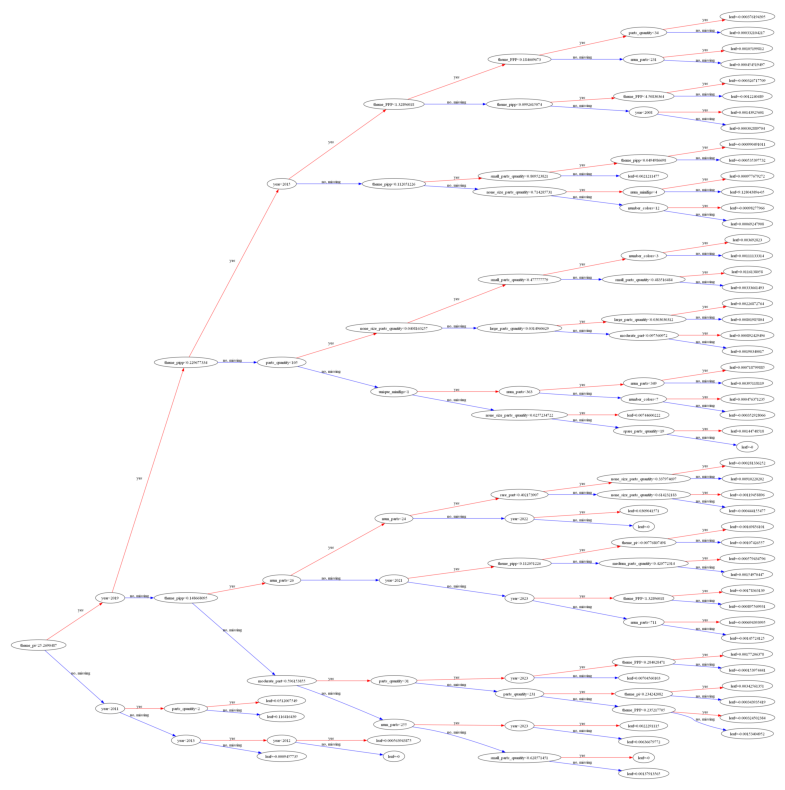

In [32]:
# This part is to visualise the tree model.
# graphviz is required to install, both python library and graphviz software
# This part is relatively useless due to too many nodes. Feel free to skip it.


try:
    fig, ax = plt.subplots(figsize=(10, 10))  
    xgb.plot_tree(temp_model, num_trees=0, rankdir='LR', ax=ax)  

    fig = plt.gcf()
    plt.show()
    fig.savefig('tree.png')
except Exception as e:
    print("An error occurred:", e)
    print("graphviz is required")

In [33]:
temp_model = ridge_model(df_msrp, feature_names + ['theme_pi', 'theme_pipp'],random_state = 2024,target = 'price_increase_per_year')[-1]
temp_model 

R-squared Score: 0.2226226660950088
Root Mean Squared Error: 0.24841284735930752
Best Parameters: {'alpha': 1}


Ridge(alpha=1)

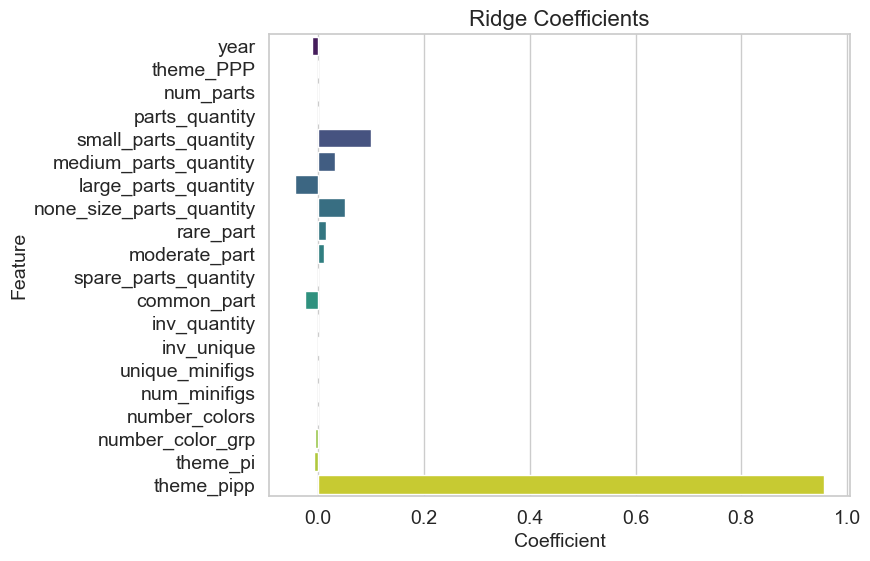

In [34]:
ridge = temp_model


coefficients = ridge.coef_
coefficients_df = pd.DataFrame({'Feature': feature_names + ['theme_pi', 'theme_pipp'], 'Coefficient': coefficients})

# barplot for coefficients
plt.figure(figsize=(7.5, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, palette='viridis')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Ridge Coefficients',fontsize = title_fontsize)
plt.show()


In [35]:
result_in_search = xgb_model_random_search(df1,feature_names,random_state=2024, n_iter=20)[2]


Best Parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0.5, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, 'regressor__gamma': 1.0, 'regressor__colsample_bytree': 0.8}
Mean R-squared Score (k-fold CV): 0.5063240904108172
[0.63341378 0.53600156 0.65119199 0.16713847 0.54387465]




In [36]:
# models performance in df_all

key = 'Data_combined'
value = dict_df[key]
temp = {}
for i in range(3):
    t=[]
    for random_state in [123,456,789,2023,2024]:
        for n_splits in [4]:
            k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            X = value[feature_names]
            y = value['price']
            t.append( np.mean( cross_val_score(xgb_models[i][-1], X, y, cv=k_fold, scoring='r2') ) )
    temp[key] = t[:]
    print(t)
    i += 1

[0.37033219699791964, 0.3726271357154862, 0.38515346132098705, 0.3795364152536193, 0.34543414032704134]
[0.37033219699791964, 0.3726271357154862, 0.38515346132098705, 0.3795364152536193, 0.34543414032704134]
[0.34457662729939187, 0.33172368223460025, 0.35228695795246073, 0.34333724087080375, 0.31801895311185235]


In [37]:
with open(PKL_RES, 'rb') as file:
    result_search = pickle.load(file)


for i in result_search[:0]:
    print(i['model'] )
    #print(i['result']
    print(i['param'])
    
for i in result_search[:]:
    if i['model'][3] =='df1'and i['model'][2] == 15:
        print(i['model'])
        print(i['param'])
        print(i['results']['mean_test_score'].mean(), i['results']['std_test_score'].mean())

#

['xgb_model_random_search', 123, 15, 'df1']
{'regressor__learning_rate': 0.09198522878911536, 'regressor__max_depth': 5, 'regressor__n_estimators': 952}
-0.00473156885445466 0.5876626188875471
['xgb_model_random_search', 456, 15, 'df1']
{'regressor__learning_rate': 0.30474711475893057, 'regressor__max_depth': 6, 'regressor__n_estimators': 949}
0.10317809239034048 0.4626716221415264
['xgb_model_random_search', 789, 15, 'df1']
{'regressor__learning_rate': 0.12883412054169915, 'regressor__max_depth': 6, 'regressor__n_estimators': 699}
-0.017470916485800563 0.377548980946669


In [38]:
#xgb_model_random_search(df1, feature_names, target=['price'],random_state = 789,k=4,n_iter=5)
datetime.datetime.now()

datetime.datetime(2024, 2, 15, 22, 22, 19, 717742)

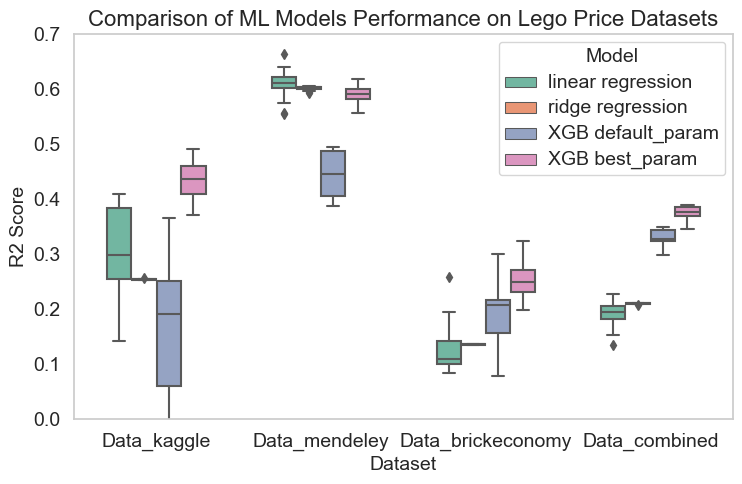

In [39]:
sns.set_style("whitegrid")
r2_scores = {}
for model, model_result in {'linear regression': model_results_linear,
                            'ridge regression': model_results_ridge,
                            'XGB default_param': model_results_xgb,
                            'XGB best_param': model_results_xgb_kfold_search}.items():
    r2_scores[model] = []
    for df,result in model_result.items():
        r2_scores[model].append(result)


model_names = ['linear regression', 'ridge regression', 'XGB default_param', 'XGB best_param']
dataset_names = ['Data_kaggle','Data_mendeley','Data_brickeconomy', 'Data_combined']
data = []
for dataset in dataset_names:
    for model in model_names:
        data.extend([(model, dataset, r2_score) for r2_score in r2_scores[model][dataset_names.index(dataset)]])

df = pd.DataFrame(data, columns=['Model', 'Dataset', 'R2 Score'])


plt.figure(figsize=(8.5, 5))
sns.boxplot(x='Dataset', y='R2 Score', hue='Model', data=df, palette='Set2',width = 0.6)

plt.xlabel('Dataset')
plt.ylabel('R2 Score')
plt.ylim(0,0.7)


fig = plt.gcf()
texts = fig.findobj(plt.Text)
for text in texts:
    text.set_fontsize(label_fontsize)
plt.title('Comparison of ML Models Performance on Lego Price Datasets',fontsize = title_fontsize)

plt.grid(False)

plt.show()


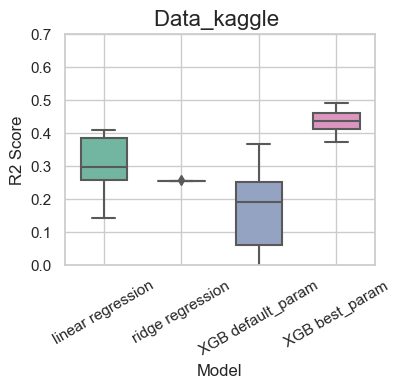

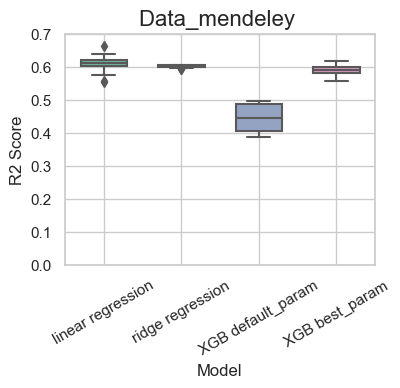

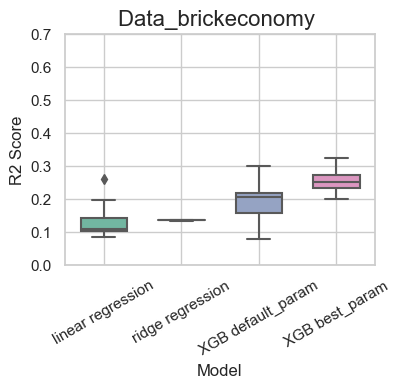

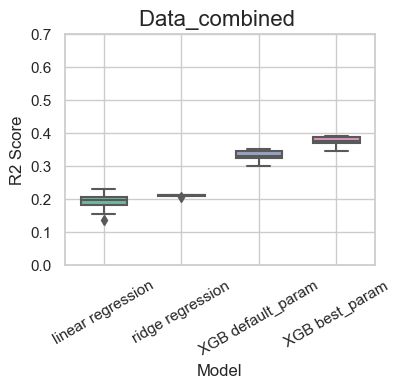

In [40]:

r2_scores = {}
for model, model_result in {'linear regression': model_results_linear,
                            'ridge regression': model_results_ridge,
                            'XGB default_param': model_results_xgb,
                            'XGB best_param': model_results_xgb_kfold_search}.items():
    r2_scores[model] = []
    for df, result in model_result.items():
        r2_scores[model].append(result)

model_names = ['linear regression', 'ridge regression', 'XGB default_param', 'XGB best_param']
dataset_names = ['Data_kaggle', 'Data_mendeley', 'Data_brickeconomy', 'Data_combined']

title_fontsize = 16
label_fontsize = 12

for dataset in dataset_names:
    data = []
    for model in model_names:
        data.extend([(model, dataset, r2_score) for r2_score in r2_scores[model][dataset_names.index(dataset)]])
    df = pd.DataFrame(data, columns=['Model', 'Dataset', 'R2 Score'])

    plt.figure(figsize=(4,3))
    sns.boxplot(x='Model', y='R2 Score', data=df, palette='Set2', width=0.6)
    plt.xlabel('Model', fontsize=label_fontsize)
    plt.ylabel('R2 Score', fontsize=label_fontsize)
    plt.xticks(rotation=30)
    plt.ylim(0, 0.7)
    plt.title(f'{dataset} ', fontsize=title_fontsize)
    plt.grid(True)
    plt.show()

In [41]:
# truncate data with 5% and 95% quantile
price_min = df_all['price'].quantile(0.05)  
price_max = df_all['price'].quantile(0.95) 
truncated_data = df_all[(df_all['price'] >= price_min) & (df_all['price'] <= price_max)]
truncated_data

set_num       theme_parent_name    year  theme_PPP  num_parts  \
0       659-1                Legoland  1975.0   1.422024       49.0   
1       314-1                    Boat  1976.0   2.008146       53.0   
2       369-1                Legoland  1976.0   1.422024      274.0   
3       485-1                Legoland  1976.0   1.422024       72.0   
4       787-1  Universal Building Set  1977.0   2.474060        1.0   
...       ...                     ...     ...        ...        ...   
2703  80036-1              Monkie Kid  2022.0   0.230347     2187.0   
2704  80030-1              Monkie Kid  2022.0   0.230347      310.0   
2705  80031-1              Monkie Kid  2022.0   0.230347      456.0   
2706  80032-1              Monkie Kid  2022.0   0.230347      609.0   
2707  80035-1              Monkie Kid  2022.0   0.230347     1356.0   

      parts_quantity  small_parts_quantity  medium_parts_quantity  \
0               10.0              0.000000               0.900000   
1               10.0              0.000000               0.400000   
2               69.0              0.115942               0.666667   
3               16.0              0.000000               0.437500   
4                1.0              0.000000               0.000000   
...              ...                   ...                    ...   
2703          1056.0              0.464481               0.161202   
2704           165.0              0.563636               0.224242   
2705           241.0              0.359684               0.209486   
2706           304.0              0.425466               0.239130   
2707           620.0              0.408065               0.250000   

      large_parts_quantity  none_size_parts_quantity  ...  moderate_part  \
0                 0.000000                  0.000000  ...       0.000000   
1                 0.400000                  0.200000  ...       0.000000   
2                 0.101449                  0.101449  ...       0.260870   
3                 0.187500                  0.375000  ...       0.062500   
4                 0.000000                  1.000000  ...       0.000000   
...                    ...                       ...  ...            ...   
2703              0.115665                  0.199454  ...       0.332423   
2704              0.078788                  0.096970  ...       0.509091   
2705              0.063241                  0.284585  ...       0.379447   
2706              0.114907                  0.142857  ...       0.332298   
2707              0.125806                  0.198387  ...       0.348387   

      spare_parts_quantity  common_part  inv_quantity  inv_unique  \
0                      0.0     0.100000           1.0           1   
1                      0.0     0.500000           1.0           1   
2                      0.0     0.028986           1.0           1   
3                      0.0     0.125000           1.0           1   
4                      0.0     0.000000           1.0           1   
...                    ...          ...           ...         ...   
2703                  42.0     0.367942           1.0           1   
2704                   0.0     0.187879           1.0           1   
2705                  12.0     0.292490           1.0           1   
2706                  18.0     0.332298           1.0           1   
2707                   0.0     0.369355           1.0           1   

      unique_minifigs  num_minifigs  number_colors  number_color_grp     price  
0                 2.0           1.0              3                 2   55.0000  
1                 2.0           1.0              3                 1  149.2976  
2                 5.0           1.0              7                 2  250.0000  
3                 3.0           1.0              3                 1  165.0000  
4                 0.0           0.0              1                 1   90.0000  
...               ...           ...            ...               ...       ...  
2703           

In [42]:
datetime.datetime.now()

datetime.datetime(2024, 2, 15, 22, 22, 21, 77884)

In [43]:
res_linear = {}
#for i,df in dict_df.items(): 
if False:
    result = {'r2_scores':{},'rmse_scores':{}}
    for test_size in [0.2,0.25,0.3]:
        result['r2_scores'][test_size] = []
        result['rmse_scores'][test_size] = []
        for random_state in range(20):
            scores = linear_regression(df, feature_names,random_state=random_state,test_size=test_size)[0]
            result['r2_scores'][test_size].append(scores[0])
            result['rmse_scores'][test_size].append(scores[1])
    res_linear[i] = result.copy()
        
#for df_name in dict_df.keys():
if False:
    for key, values in res_linear[df_name]['r2_scores'].items():
        print(f'mean R2 of {df_name}, {key}: {np.mean(values):.3f} ')
    print('\n')
    for key, values in res_linear[df_name]['r2_scores'].items():
        print(f'std R2 of {df_name}, {key}: {np.std(values):.3f} ')
    print('\n-----------')

In [44]:
model = linear_regression(df1,feature_names=feature_names)[-1].named_steps['regressor']
coefficients = model.coef_[0]
print('\n-----\n')
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef:.2f}')


Root Mean Squared Error: 86.82661094243623
R-squared Score: 0.4089559092478293

-----

year: -4.34
theme_PPP: 5.14
num_parts: 0.06
parts_quantity: 0.07
small_parts_quantity: -21.81
medium_parts_quantity: -23.39
large_parts_quantity: 3.20
none_size_parts_quantity: 20.56
rare_part: 194.01
moderate_part: 214.12
spare_parts_quantity: -2.18
common_part: 223.60
inv_quantity: 7.12
inv_unique: -15.08
unique_minifigs: 16.64
num_minifigs: -10.70
number_colors: 2.04
number_color_grp: -1.21


Root Mean Squared Error: 86.82661094243623
R-squared Score: 0.4089559092478293


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Root Mean Squared Error: 141.6208818115819
R-squared Score: 0.5541465836036115


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Root Mean Squared Error: 340.62332948931123
R-squared Score: 0.0839408643561057


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Root Mean Squared Error: 226.05605494485417
R-squared Score: 0.22796816642837103


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


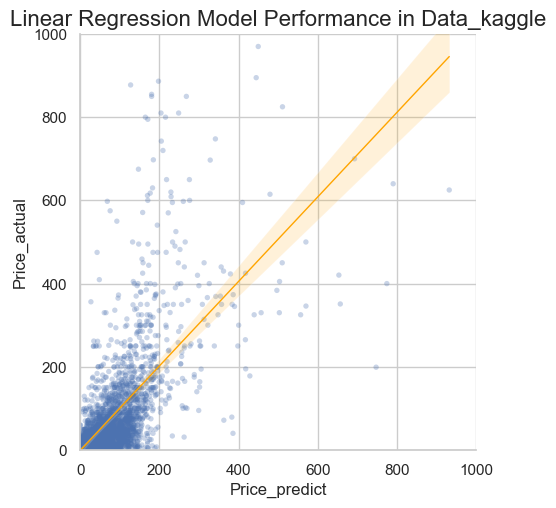

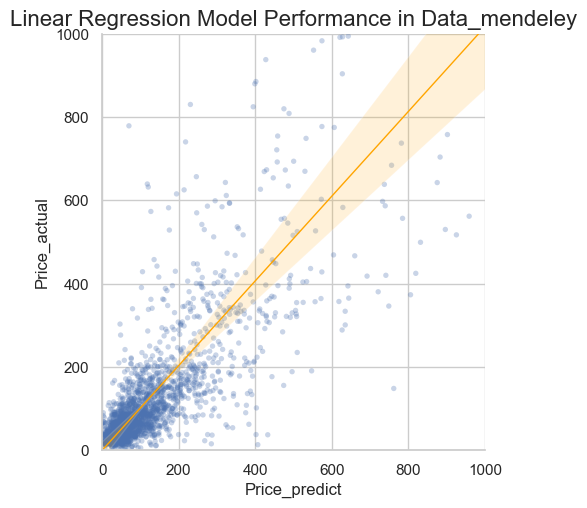

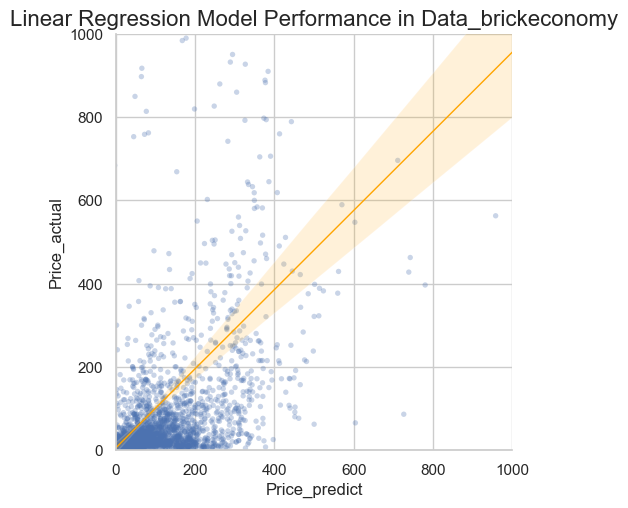

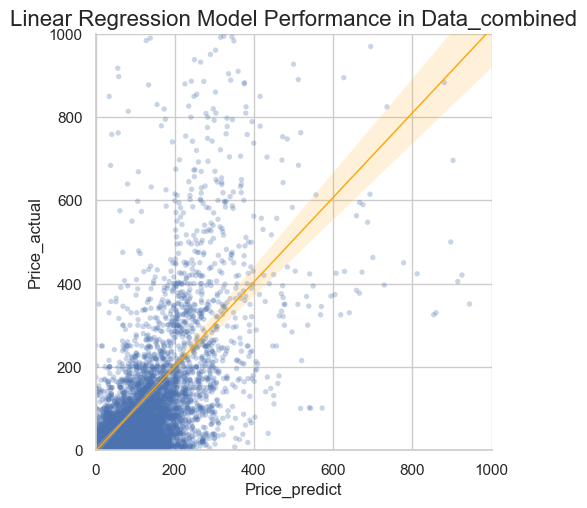

In [45]:
dfs = [df1,df2,df3,df_all]
dataset_names = ['Data_kaggle','Data_mendeley','Data_brickeconomy','Data_combined']
lim = 1000
scatter_kws={'alpha':0.3,'edgecolor':'none','s':15}
line_kws={'color': 'orange','linewidth':1}
x='Price_predict'
y='Price_actual'

for i in range(4):
    df = dfs[i]
    model = linear_regression(df,feature_names=feature_names)[-1]
    y_predict = model.predict(df[feature_names]).flatten() 
    y_actual = df['price']
    df = pd.DataFrame({x:y_predict,y:y_actual})
    sns.lmplot(x=x, y=y,data=df, scatter_kws=scatter_kws, line_kws=line_kws, height=5, aspect=1)
    plt.xlim(0,lim)
    plt.ylim(0,lim)
    plt.title(f'Linear Regression Model Performance in {dataset_names[i]}',fontsize = title_fontsize)

R-squared Score: 0.25382775693071546
Root Mean Squared Error: 126.60203493855646
Best Parameters: {'alpha': 500}


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


R-squared Score: 0.604774070227287
Root Mean Squared Error: 144.56142959771685
Best Parameters: {'alpha': 100}


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


R-squared Score: 0.13654856860220588
Root Mean Squared Error: 297.85784160329916
Best Parameters: {'alpha': 10}


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


R-squared Score: 0.21126985069430304
Root Mean Squared Error: 209.66388946495064
Best Parameters: {'alpha': 50}


C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


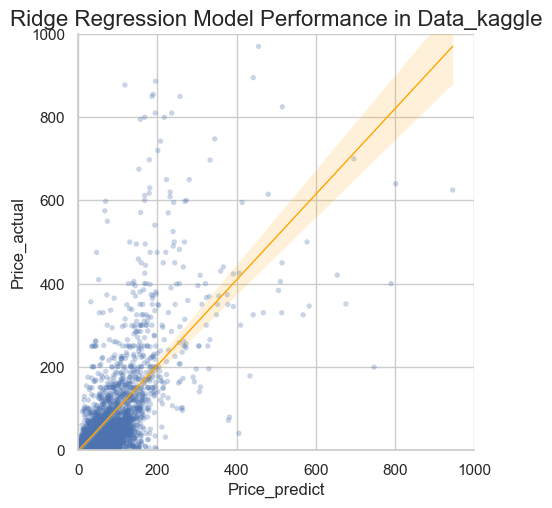

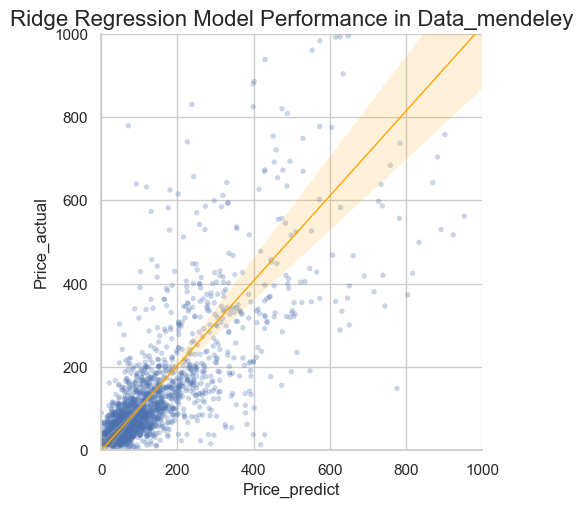

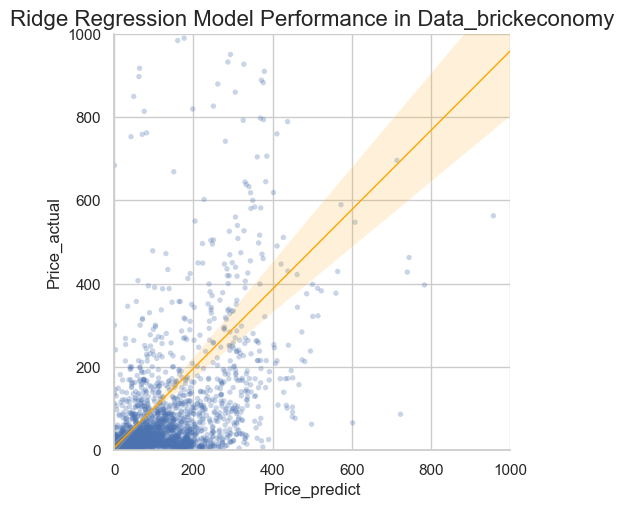

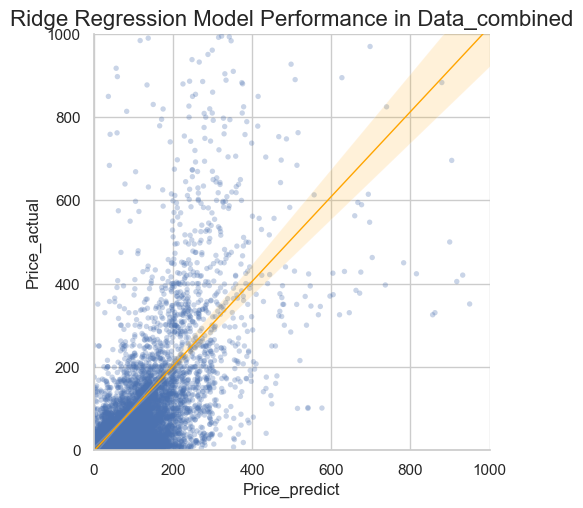

In [46]:
for i in range(4):
    df = dfs[i]
    model = ridge_model(df,feature_names=feature_names)[-1]
    y_predict = model.predict(df[feature_names]).flatten() 
    y_actual = df['price']
    df = pd.DataFrame({x:y_predict,y:y_actual})
    sns.lmplot(x=x, y=y,data=df, scatter_kws=scatter_kws, line_kws=line_kws, height=5, aspect=1)
    plt.xlim(0,lim)
    plt.ylim(0,lim)
    plt.title(f'Ridge Regression Model Performance in {dataset_names[i]}',fontsize = title_fontsize)

C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


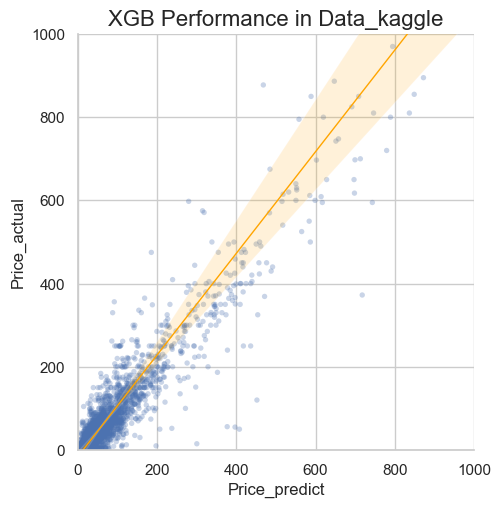

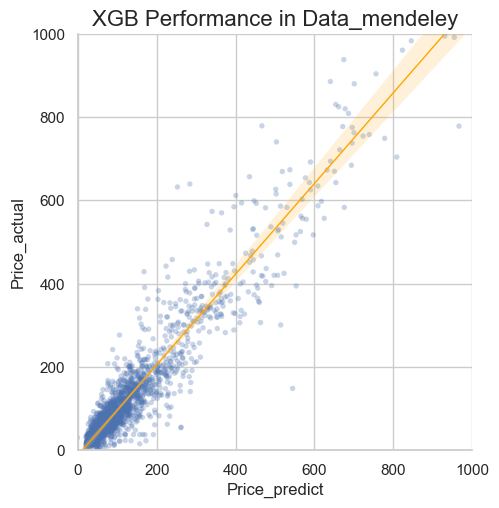

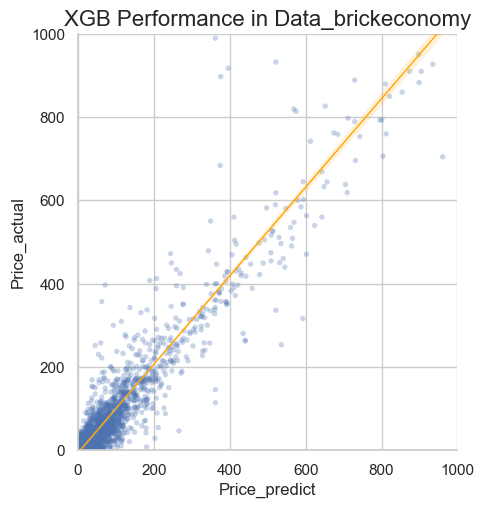

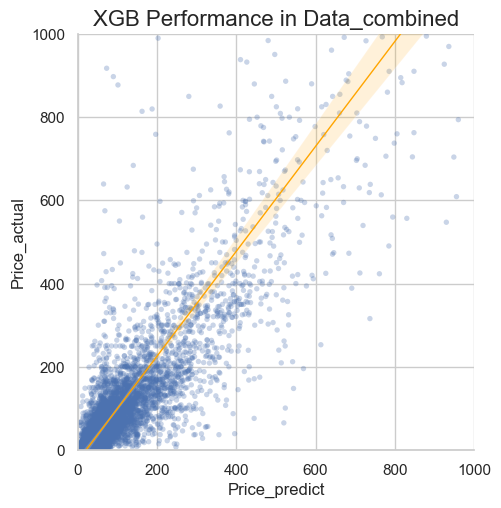

In [47]:
# xgb results

lim = 1000
scatter_kws={'alpha':0.3,'edgecolor':'none','s':15}
line_kws={'color': 'orange','linewidth':1}
x='Price_predict'
y='Price_actual'

dfs = [df1,df2,df3,df_all]
for i in range(4):
    model = xgb_models[i][-1]
    df = dfs[i]
    y_predict = model.predict(df[feature_names]).flatten() 
    y_actual = df['price']
    df = pd.DataFrame({x:y_predict,y:y_actual})
    sns.lmplot(x=x, y=y,data=df, scatter_kws=scatter_kws, line_kws=line_kws,height=5, aspect=1)
    plt.xlim(0,lim)
    plt.ylim(0,lim)
    plt.title(f'XGB Performance in {dataset_names[i]}',fontsize = title_fontsize)

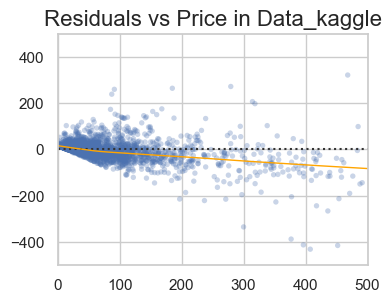

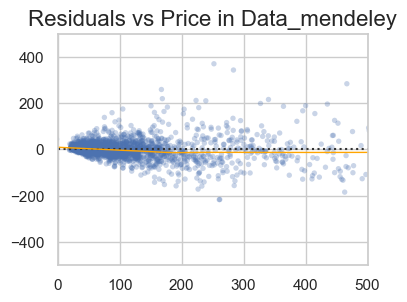

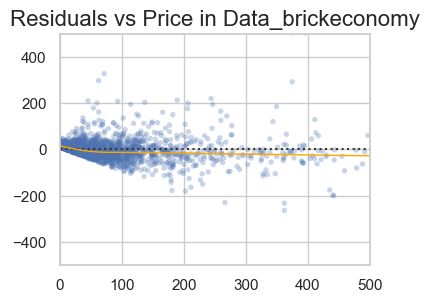

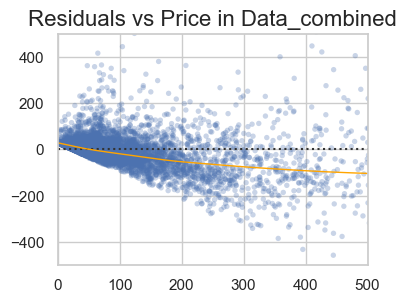

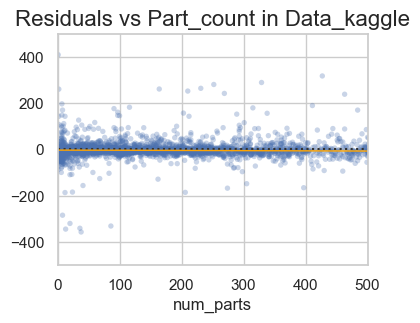

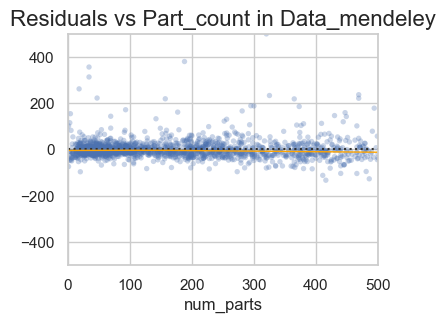

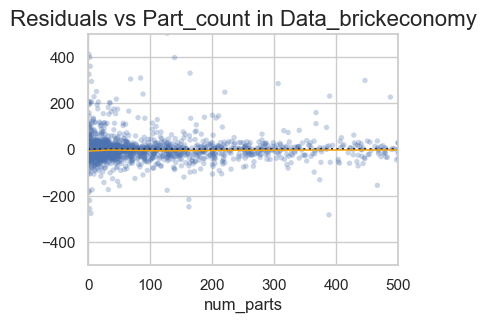

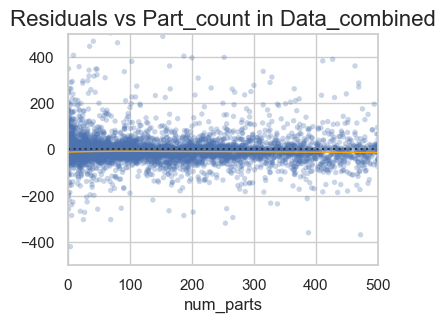

In [48]:
# residuals analysis for xgb model 
# pay attention to df2, espically the distribution of num_parts

lim=500
figsize = (4,3)

# residuals relating to price
for i in range(4):
    df = dfs[i]
    model = xgb_models[i][-1]
    y_predict = model.predict(df[feature_names]).flatten() 
    y_actual = df['price']
    residuals = np.array(y_actual) - np.array(y_predict)
    
    plt.figure(figsize=figsize)
    sns.residplot(x=np.array(y_predict), y=residuals, lowess=True,scatter_kws=scatter_kws, line_kws=line_kws)
    plt.xlim(0,lim)
    plt.ylim(-lim,lim)
    plt.title(f'Residuals vs Price in {dataset_names[i]}',fontsize = title_fontsize)
    plt.show()
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)
    
    #print("Mean of residuals:", mean_residuals)
    #print("Standard deviation of residuals:", std_residuals)

    

# residuals relating to num_parts
for i in range(4):

    df = dfs[i]
    model = xgb_models[i][-1]
    y_predict = model.predict(df[feature_names]).flatten() 
    y_actual = df['price']
    residuals = np.array(y_actual) - np.array(y_predict)
    
    plt.figure(figsize=figsize)
    #sns.residplot(x=np.array(y_predict), y=residuals, lowess=True,scatter_kws=scatter_kws, line_kws=line_kws)
    sns.residplot(x=df['num_parts'], y=residuals, lowess=True,scatter_kws=scatter_kws, line_kws=line_kws)
    plt.title(f'Residuals vs Part_count in {dataset_names[i]}',fontsize = title_fontsize)
    plt.xlim(0,lim)
    plt.ylim(-lim,lim)
    plt.show()
    



C:\Users\niels\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


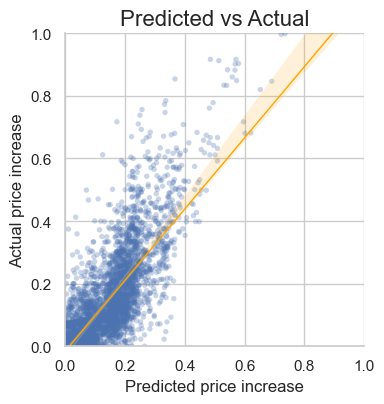

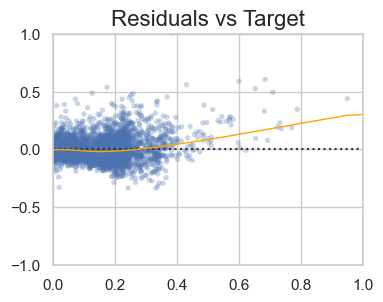

In [49]:
x,y = 'Predicted price increase','Actual price increase'

y_predict = price_increaes_model.predict(df_msrp[feature_names + ['theme_pi', 'theme_pipp']]).flatten() 
y_actual = df_msrp['price_increase_per_year']
residuals = np.array(y_actual) - np.array(y_predict)
df = pd.DataFrame({x:y_predict, y:y_actual})
sns.lmplot(x=x, y=y,data=df, scatter_kws=scatter_kws, line_kws=line_kws,height=4, aspect=1)
plt.title(f'Predicted vs Actual',fontsize = title_fontsize)
plt.xlim(0,1)
plt.ylim(0,1)

    
plt.figure(figsize=figsize)
sns.residplot(x=np.array(y_predict), y=residuals, lowess=True,scatter_kws=scatter_kws, line_kws=line_kws)
plt.xlim(0,1)
plt.ylim(-1,1)
plt.title(f'Residuals vs Target',fontsize = title_fontsize)
plt.show()

(-50.0, 300.0)

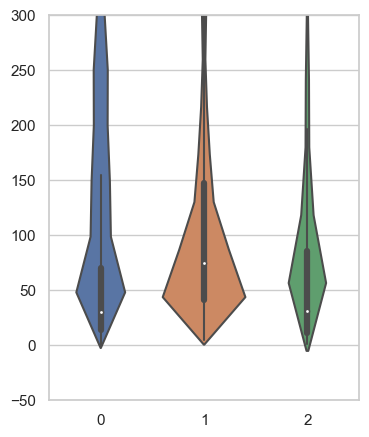

In [50]:
data = [df1['price'], df2['price'], df3['price']]

sns.violinplot(data=data,bw=0.01)
plt.ylim(-50,300)


In [51]:
data[1].min()

4.732764375

In [52]:
df1['price'].mean()

69.35708738305266